# Notebook 3: Survival Analysis and Predictive Modeling

**Objective**: Predict probability and timing of exit events (IPO, M&A) for VC-backed startups.

**Methods**:
1. Kaplan-Meier estimation
2. Cox Proportional Hazards
3. Competing Risks (Fine-Gray)
4. Random Survival Forest
5. Classification comparison

In [1]:
%load_ext autoreload
# Autoreload everything
%autoreload 2

import config

## 1. Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import AalenJohansenFitter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

SEED = 42
np.random.seed(SEED)

# Configurazione paths

# Crea directories
config.OUTPUT_PATH.mkdir(exist_ok=True)

In [3]:
df = pd.read_csv(config.FINAL_PATH / 'finale_usa_cleaned.csv', low_memory=False)

print(f'Shape: {df.shape}')
print(f'Events: {df["event"].sum()} / {len(df)} ({100*df["event"].mean():.1f}%)')
print(f'Duration: median={df["duration_years"].median():.2f}, range=[{df["duration_years"].min():.2f}, {df["duration_years"].max():.2f}]')

Shape: (15304, 53)
Events: 1638 / 15304 (10.7%)
Duration: median=3.00, range=[0.02, 30.00]


In [4]:
event_dist = df['event_type'].value_counts().sort_index()
event_labels = {0: 'Censored', 1: 'IPO', 2: 'M&A', 3: 'Failure'}

for idx, count in event_dist.items():
    print(f'{event_labels[idx]}: {count} ({100*count/len(df):.1f}%)')

Censored: 12796 (83.6%)
IPO: 125 (0.8%)
M&A: 1513 (9.9%)
Failure: 870 (5.7%)


In [5]:
NUMERIC = ['log_fund_tot', 'funding_rounds', 'market_heat', 'relationships', 
           'milestones', 'angel', 'series_a', 'series_b', 'series_c', 'venture']

CATEGORICAL = ['macro_settore', 'market_cycle']

T = 'duration_years'
E = 'event'
E_TYPE = 'event_type'

df_model = df[NUMERIC + CATEGORICAL + [T, E, E_TYPE]].copy()
print(f'Model dataset: {df_model.shape}, missing: {df_model.isnull().sum().sum()}')

Model dataset: (15304, 15), missing: 0


## 2. Kaplan-Meier Analysis

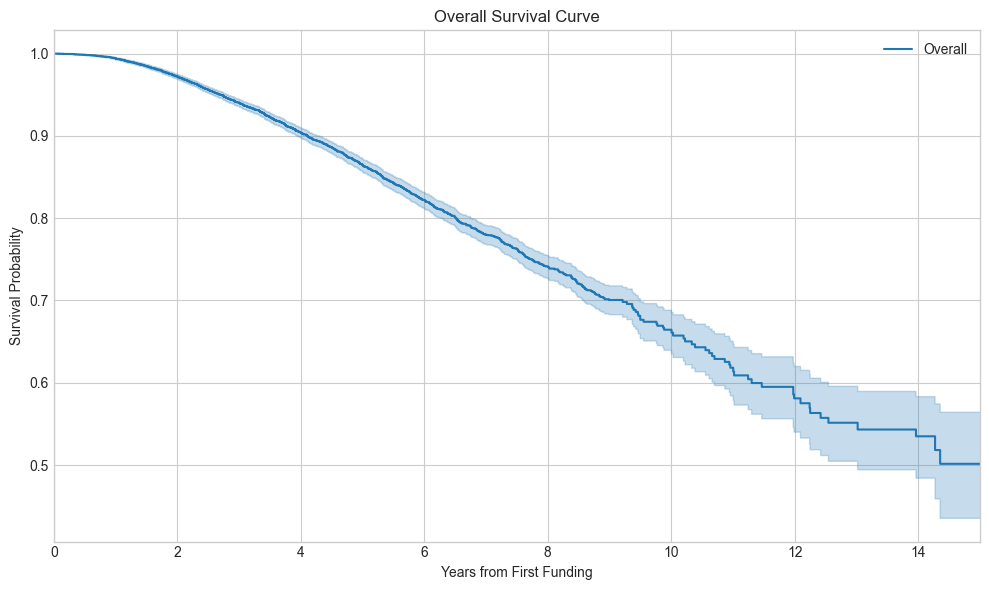

Median survival: inf years
S(1yr): 99.4%
S(3yr): 94.0%
S(5yr): 86.5%
S(10yr): 66.5%


In [6]:
kmf = KaplanMeierFitter()
kmf.fit(df_model[T], df_model[E], label='Overall')

fig, ax = plt.subplots()
kmf.plot_survival_function(ax=ax, ci_show=True)
ax.set_xlabel('Years from First Funding')
ax.set_ylabel('Survival Probability')
ax.set_title('Overall Survival Curve')
ax.set_xlim(0, 15)
plt.tight_layout()
plt.show()

print(f'Median survival: {kmf.median_survival_time_:.2f} years')
for t in [1, 3, 5, 10]:
    print(f'S({t}yr): {kmf.predict(t):.1%}')

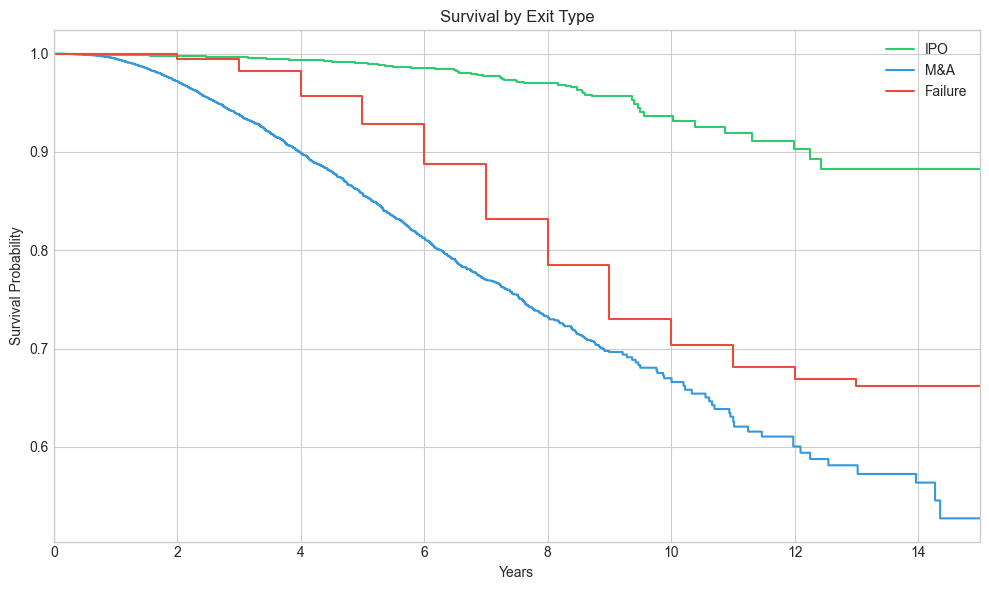

In [7]:
fig, ax = plt.subplots()
colors = {1: '#2ecc71', 2: '#3498db', 3: '#e74c3c'}
labels = {1: 'IPO', 2: 'M&A', 3: 'Failure'}

for etype in [1, 2, 3]:
    mask = df_model[E_TYPE].isin([0, etype])
    event_bin = (df_model.loc[mask, E_TYPE] == etype).astype(int)
    kmf_sub = KaplanMeierFitter()
    kmf_sub.fit(df_model.loc[mask, T], event_bin, label=labels[etype])
    kmf_sub.plot_survival_function(ax=ax, ci_show=False, color=colors[etype])

ax.set_xlabel('Years')
ax.set_ylabel('Survival Probability')
ax.set_title('Survival by Exit Type')
ax.set_xlim(0, 15)
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
def plot_km_by_group(data, group_col, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for grp in sorted(data[group_col].dropna().unique()):
        mask = data[group_col] == grp
        kmf_g = KaplanMeierFitter()
        kmf_g.fit(data.loc[mask, T], data.loc[mask, E], label=str(grp))
        kmf_g.plot_survival_function(ax=ax, ci_show=False)
    
    ax.set_xlabel('Years')
    ax.set_ylabel('Survival Probability')
    ax.set_title(title)
    ax.set_xlim(0, 15)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    result = multivariate_logrank_test(data[T], data[group_col], data[E])
    print(f'Log-rank: chi2={result.test_statistic:.2f}, p={result.p_value:.2e}')
    return result.p_value

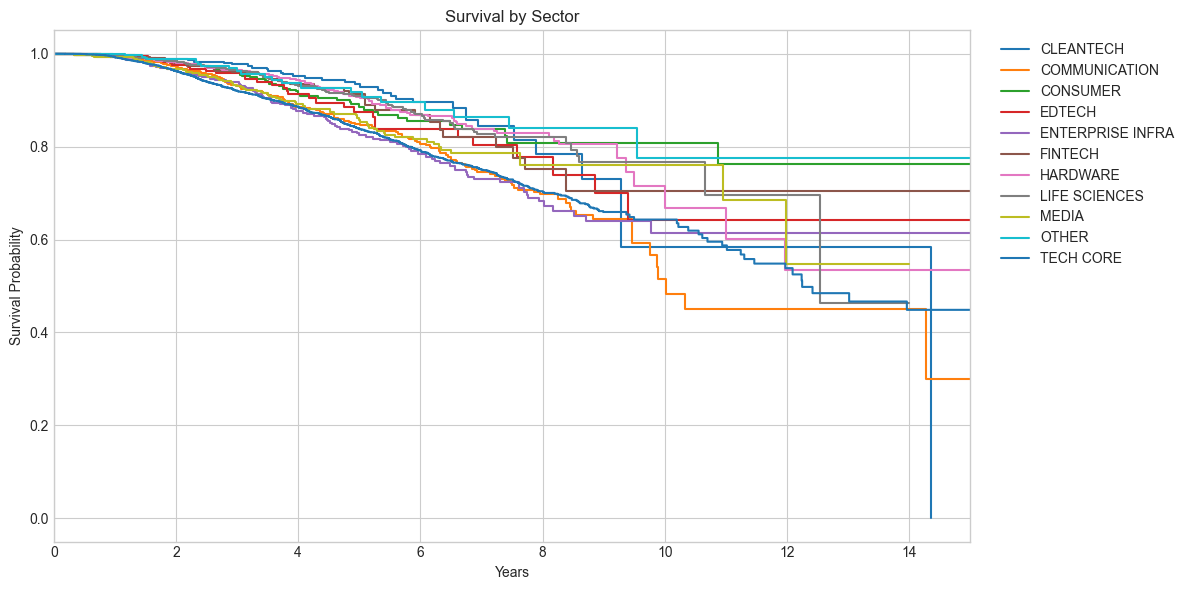

Log-rank: chi2=102.22, p=1.96e-17


In [9]:
p_sector = plot_km_by_group(df_model, 'macro_settore', 'Survival by Sector')

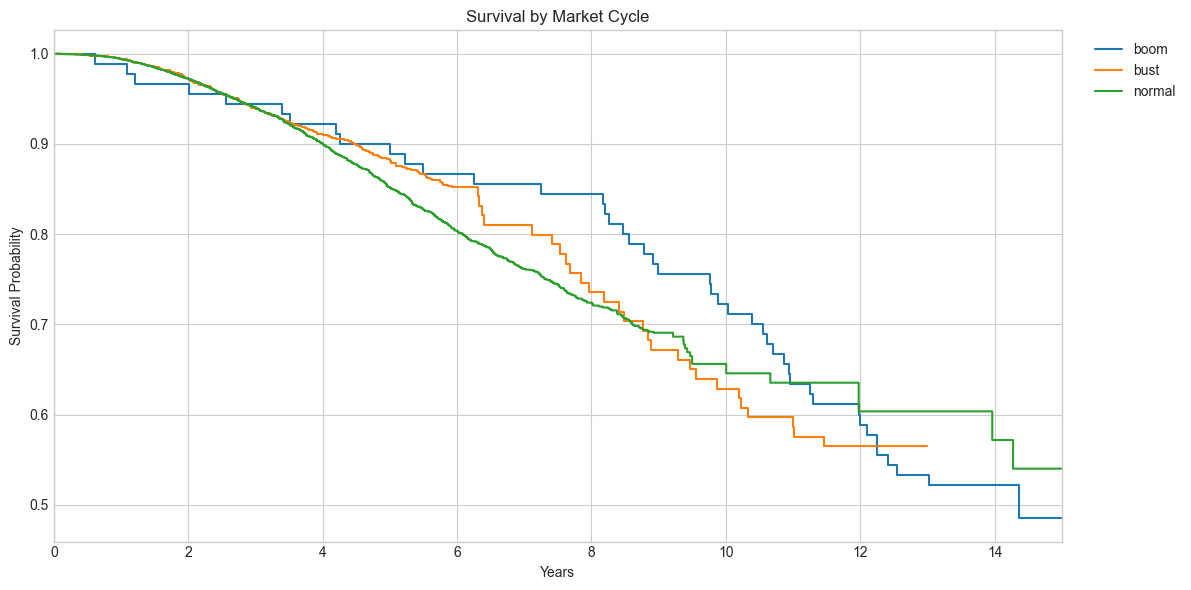

Log-rank: chi2=11.70, p=2.88e-03


In [10]:
p_cycle = plot_km_by_group(df_model, 'market_cycle', 'Survival by Market Cycle')

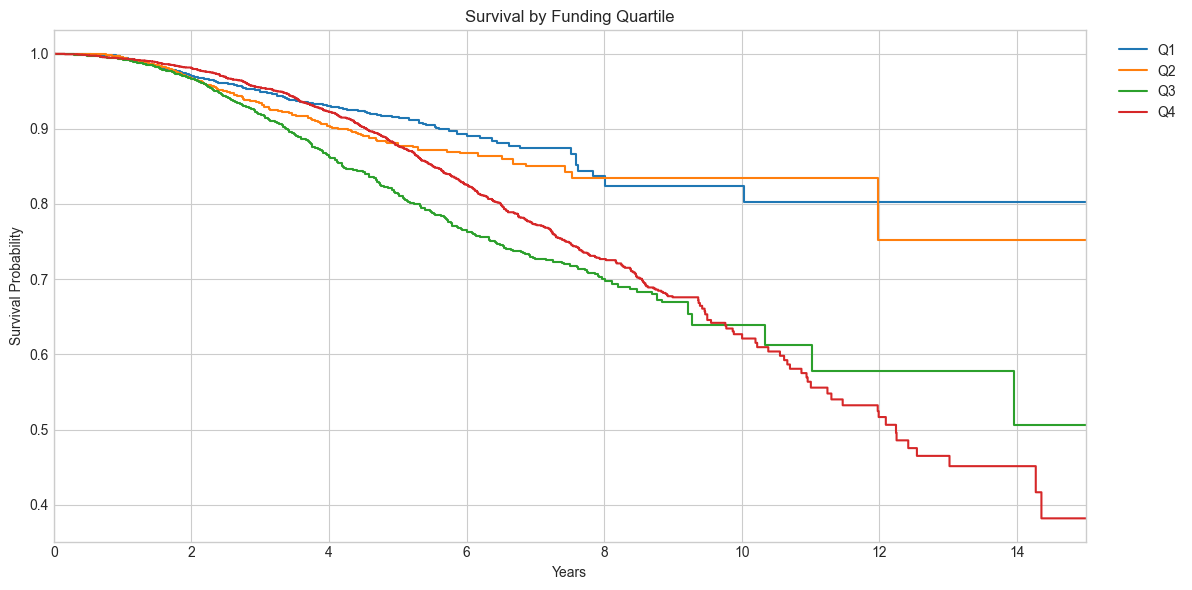

Log-rank: chi2=73.95, p=6.07e-16


In [11]:
df_model['funding_q'] = pd.qcut(df_model['log_fund_tot'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
p_funding = plot_km_by_group(df_model, 'funding_q', 'Survival by Funding Quartile')

In [12]:
logrank_results = []

test_vars = {
    'macro_settore': df_model['macro_settore'],
    'market_cycle': df_model['market_cycle'],
    'funding_q': df_model['funding_q'],
    'has_milestones': (df_model['milestones'] > 0).map({True: 'Yes', False: 'No'}),
    'high_network': (df_model['relationships'] > df_model['relationships'].median()).map({True: 'High', False: 'Low'})
}

for name, var in test_vars.items():
    res = multivariate_logrank_test(df_model[T], var, df_model[E])
    logrank_results.append({'Variable': name, 'Chi2': res.test_statistic, 
                            'p_value': res.p_value, 'Sig': res.p_value < 0.05})

lr_df = pd.DataFrame(logrank_results).sort_values('p_value')
print(lr_df.to_string(index=False))

      Variable       Chi2      p_value  Sig
has_milestones 116.288750 4.108965e-27 True
  high_network  87.430888 8.727682e-21 True
 macro_settore 102.220257 1.957105e-17 True
     funding_q  73.954192 6.070584e-16 True
  market_cycle  11.697896 2.882930e-03 True


## 3. Cox Proportional Hazards

In [13]:
df_cox = df_model.drop(columns=['funding_q']).copy()
df_cox = pd.get_dummies(df_cox, columns=CATEGORICAL, drop_first=True)
print(f'Cox dataset: {df_cox.shape}')

Cox dataset: (15304, 25)


In [14]:
features = [c for c in df_cox.columns if c not in [T, E, E_TYPE]]
uni_results = []

for feat in features:
    try:
        cph_u = CoxPHFitter()
        cph_u.fit(df_cox[[T, E, feat]], duration_col=T, event_col=E)
        s = cph_u.summary
        uni_results.append({
            'Feature': feat,
            'HR': s.loc[feat, 'exp(coef)'],
            'CI_low': s.loc[feat, 'exp(coef) lower 95%'],
            'CI_high': s.loc[feat, 'exp(coef) upper 95%'],
            'p': s.loc[feat, 'p']
        })
    except:
        pass

uni_df = pd.DataFrame(uni_results).sort_values('p')
print('Univariate Cox (top 15):')
print(uni_df.head(15).to_string(index=False))

Univariate Cox (top 15):
                       Feature       HR   CI_low  CI_high            p
                    milestones 1.278306 1.237635 1.320314 4.201968e-50
                 relationships 1.005508 1.004353 1.006664 7.160655e-21
       macro_settore_TECH CORE 1.421692 1.290201 1.566583 1.196688e-12
                funding_rounds 0.918416 0.890923 0.946758 4.061085e-08
   macro_settore_LIFE SCIENCES 0.649807 0.542947 0.777699 2.567859e-06
        macro_settore_HARDWARE 0.651909 0.526398 0.807345 8.804974e-05
                   market_heat 1.318383 1.136883 1.528860 2.546091e-04
             market_cycle_bust 0.806747 0.712422 0.913560 7.116669e-04
           market_cycle_normal 1.225414 1.087042 1.381400 8.835685e-04
        macro_settore_CONSUMER 0.680546 0.525728 0.880954 3.473028e-03
           macro_settore_OTHER 0.527476 0.342916 0.811367 3.598205e-03
   macro_settore_COMMUNICATION 1.213102 1.042822 1.411187 1.230355e-02
         macro_settore_FINTECH 0.722724 0.527946 0.9

In [15]:
# ========================================================================
# TRAIN/TEST SPLIT - UNICO PER TUTTI I MODELLI
# ========================================================================

from sklearn.model_selection import train_test_split

# Base dataset
X_all = df_cox.drop(columns=[T, E, E_TYPE])
y_t_all = df_cox[T]
y_e_all = df_cox[E]

# SPLIT UNICO
X_train_all, X_test_all, y_t_train, y_t_test, y_e_train, y_e_test = train_test_split(
    X_all, y_t_all, y_e_all,
    test_size=0.2,
    random_state=SEED,
    stratify=y_e_all
)

train_idx = X_train_all.index
test_idx = X_test_all.index

print(f'Train: {len(train_idx):,} ({y_e_train.mean():.1%} events)')
print(f'Test:  {len(test_idx):,} ({y_e_test.mean():.1%} events)')
print('='*80)

# Scaling per ML models
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_all), 
    columns=X_all.columns, 
    index=train_idx
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_all), 
    columns=X_all.columns, 
    index=test_idx
)

# Ricrea df_cox_train/test
df_cox_train = df_cox.loc[train_idx].copy()
df_cox_test = df_cox.loc[test_idx].copy()

print(f'\nCox train: {len(df_cox_train)}, test: {len(df_cox_test)}')


Train: 12,243 (10.7% events)
Test:  3,061 (10.7% events)

Cox train: 12243, test: 3061


In [16]:
# ========================================================================
# Cox PH: Train/Test Performance
# ========================================================================

print('COX PH TRAIN/TEST EVALUATION')

cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_cox_train.drop(columns=[E_TYPE]), duration_col=T, event_col=E)

# Train C-index
ci_cox_train = cph.concordance_index_

# Test C-index
cph_pred_test = cph.predict_partial_hazard(df_cox_test.drop(columns=[E_TYPE]))
ci_cox_test = concordance_index_censored(
    df_cox_test[E].astype(bool),
    df_cox_test[T],
    cph_pred_test
)[0]

print(f'Cox PH C-index:')
print(f'  Train: {ci_cox_train:.4f}')
print(f'  Test:  {ci_cox_test:.4f}')
print(f'  Overfit gap: {(ci_cox_train - ci_cox_test)*100:+.2f}%')

COX PH TRAIN/TEST EVALUATION
Cox PH C-index:
  Train: 0.6786
  Test:  0.6416
  Overfit gap: +3.70%


In [17]:
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_cox.drop(columns=['event_type']), duration_col=T, event_col=E)

print(f'C-index: {cph.concordance_index_:.4f}')
print(f'LR test p-value: {cph.log_likelihood_ratio_test().p_value:.2e}')
print('\nSignificant (p<0.05):')
sig = cph.summary[cph.summary['p'] < 0.05][
    ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']
].round(4)
print(sig.to_string())

C-index: 0.6713
LR test p-value: 2.80e-69

Significant (p<0.05):
                                exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%       p
covariate                                                                                  
log_fund_tot                       1.0178               1.0052               1.0306  0.0057
funding_rounds                     0.8290               0.7996               0.8595  0.0000
relationships                      1.0028               1.0011               1.0044  0.0010
milestones                         1.3036               1.2569               1.3520  0.0000
macro_settore_ENTERPRISE INFRA     1.3506               1.0616               1.7184  0.0144
macro_settore_OTHER                0.6676               0.4463               0.9985  0.0492
macro_settore_TECH CORE            1.2810               1.0814               1.5175  0.0042


Test Proportional Hazards:
                                test_statistic             p   -log2(p)
angel                                 0.503197  4.780988e-01   1.064619
funding_rounds                      130.418542  3.318756e-30  97.927200
log_fund_tot                          7.807777  5.202185e-03   7.586667
macro_settore_COMMUNICATION           0.067651  7.947888e-01   0.331357
macro_settore_CONSUMER                0.255377  6.133142e-01   0.705302
macro_settore_EDTECH                  0.010308  9.191318e-01   0.121656
macro_settore_ENTERPRISE INFRA        0.048273  8.260970e-01   0.275617
macro_settore_FINTECH                 0.139387  7.088909e-01   0.496364
macro_settore_HARDWARE                0.450088  5.022931e-01   0.993399
macro_settore_LIFE SCIENCES           0.381456  5.368253e-01   0.897476
macro_settore_MEDIA                   1.514065  2.185199e-01   2.194164
macro_settore_OTHER                   0.013216  9.084744e-01   0.138482
macro_settore_TECH CORE              

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 15304 total observations, 13666 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic      p  -log2(p)
angel                          km              0.11   0.74      0.43
                               rank            0.50   0.48      1.06
funding_rounds                 km            128.95 <0.005     96.86
                               rank          130.42 <0.005     97.93
log_fund_tot                   km              6.26   0.01      6.34
                               rank            7.81   0.01      7.59
macro_settore_COMMUNICATION    km              0.00   0.95      0.07
                               rank            0.07   0.79      0.33
macro_settore_CONSUMER         km              1.73   0.19      2.41
                               rank            0.26   0.61      0.71
macro_settore_EDTECH           km              0.14   0.71      0.50
                               rank            0.01   0.92      0.12
macro_settore_ENTERPRISE INFRA km              0.72   0.40      1.33
                               rank            0.05   0.83      0.28
macro_settore_FINTECH          km              0.01   0.93      0.11
                               rank            0.14   0.71      0.50
macro_settore_HARDWARE         km              0.30   0.59      0.77
                               rank            0.45   0.50      0.99
macro_settore_LIFE SCIENCES    km              0.40   0.53      0.93
                               rank            0.38   0.54      0.90
macro_settore_MEDIA            km              1.72   0.19      2.40
                               rank            1.51   0.22      2.19
macro_settore_OTHER            km              0.12   0.73      0.45
                               rank            0.01   0.91      0.14
macro_settore_TECH CORE        km              0.52   0.47      1.09
                               rank            0.53   0.46      1.11
market_cycle_bust              km              2.66   0.10      3.28
                               rank            1.03   0.31      1.69
market_cycle_normal            km              3.11   0.08      3.69
                               rank            0.07   0.80      0.33
market_heat                    km              0.58   0.45      1.16
                               rank            1.63   0.20      2.31
milestones                     km             12.41 <0.005     11.19
                               rank           15.31 <0.005     13.42
relationships                  km              1.27   0.26      1.94
                               rank            1.73   0.19      2.40
series_a                       km              0.77   0.38      1.40
                               rank            0.46   0.50      1.01
series_b                       km              0.30   0.58      0.78
                               rank            0.91   0.34      1.56
series_c                       km              0.00   0.96      0.05
                               rank            0.03   0.86      0.22
venture                        km              0.84   0.36      1.47
                               rank            2.61   0.11      3.24



1. Variable 'log_fund_tot' failed the non-proportional test: p-value is 0.0052.

   Advice 1: the functional form of the variable 'log_fund_tot' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'log_fund_tot' using pd.cut, and then specify it in
`strata=['log_fund_tot', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'funding_rounds' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'funding_rounds' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
fu

[[<Axes: xlabel='rank-transformed time\n(p=0.0052)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0124)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2016)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4471)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1889)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2601)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0004)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4781)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7411)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4978)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3801)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3396)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5836)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8598)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9630)'>],
 [<Axes: xlabel='rank-transformed tim

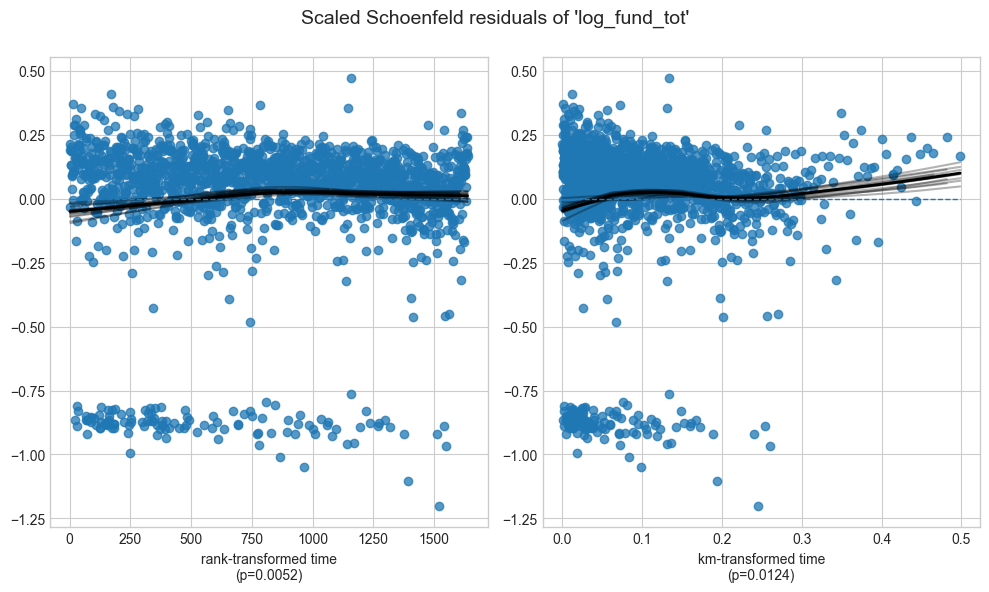

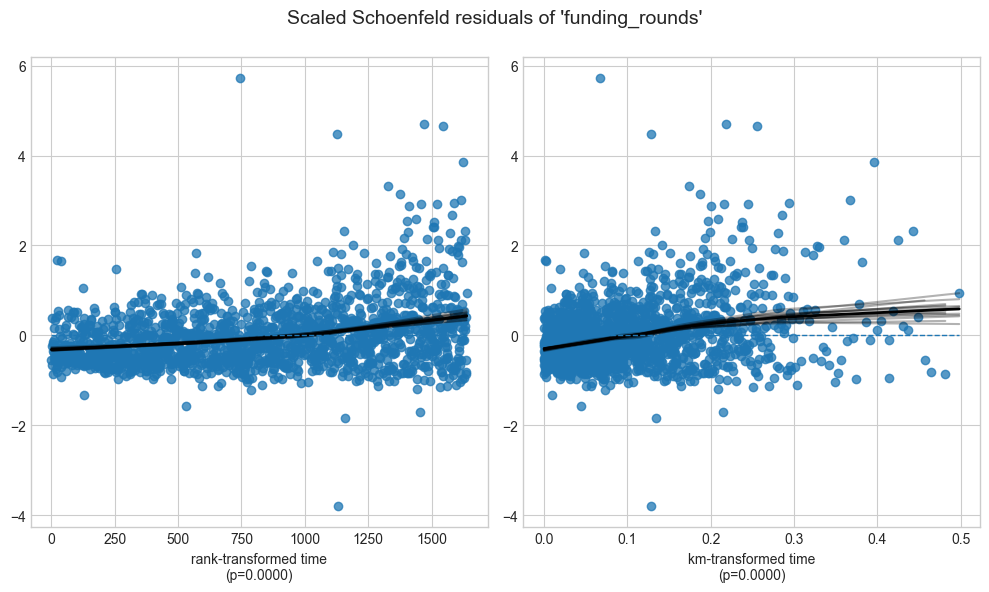

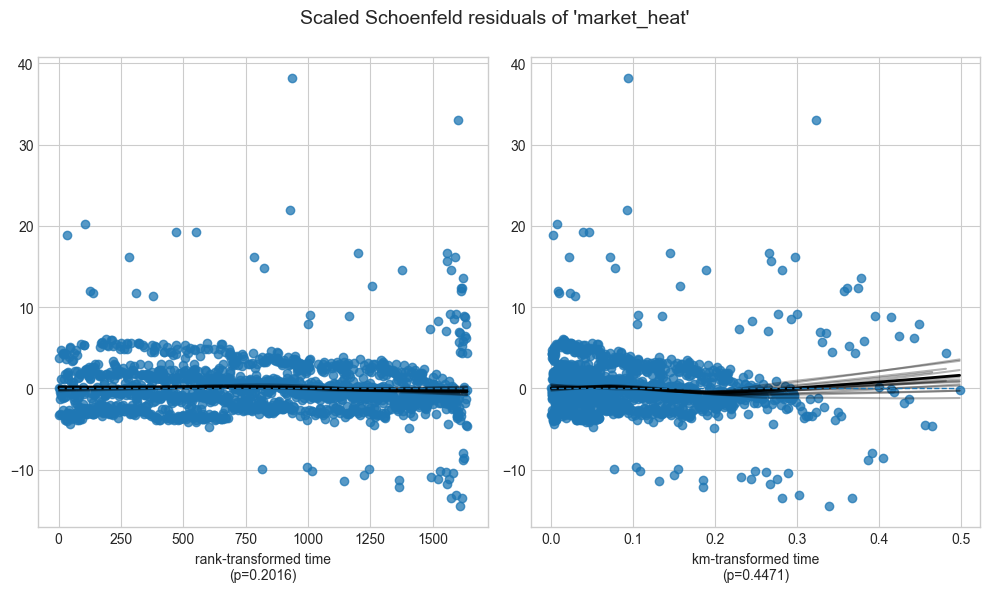

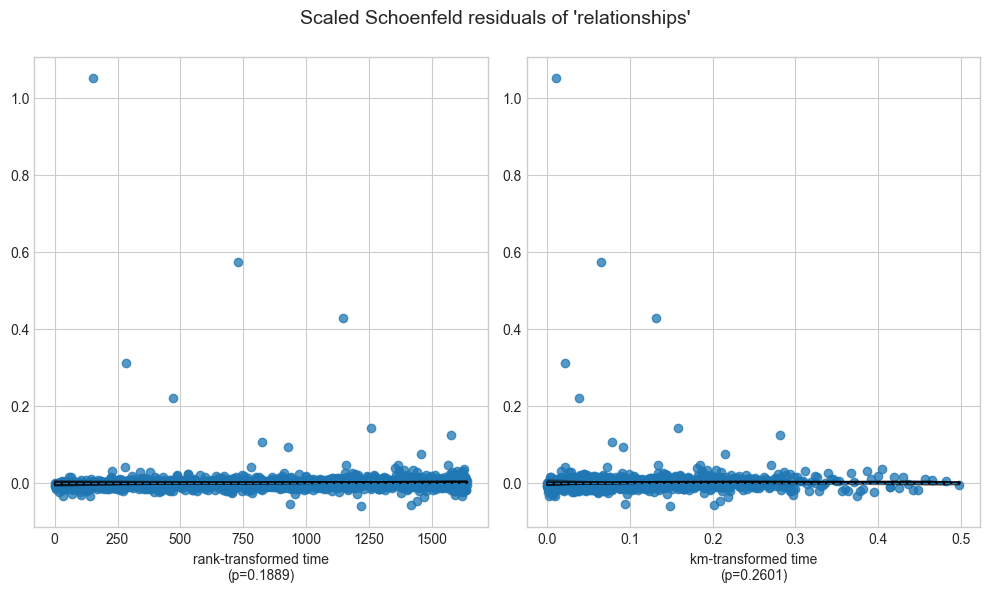

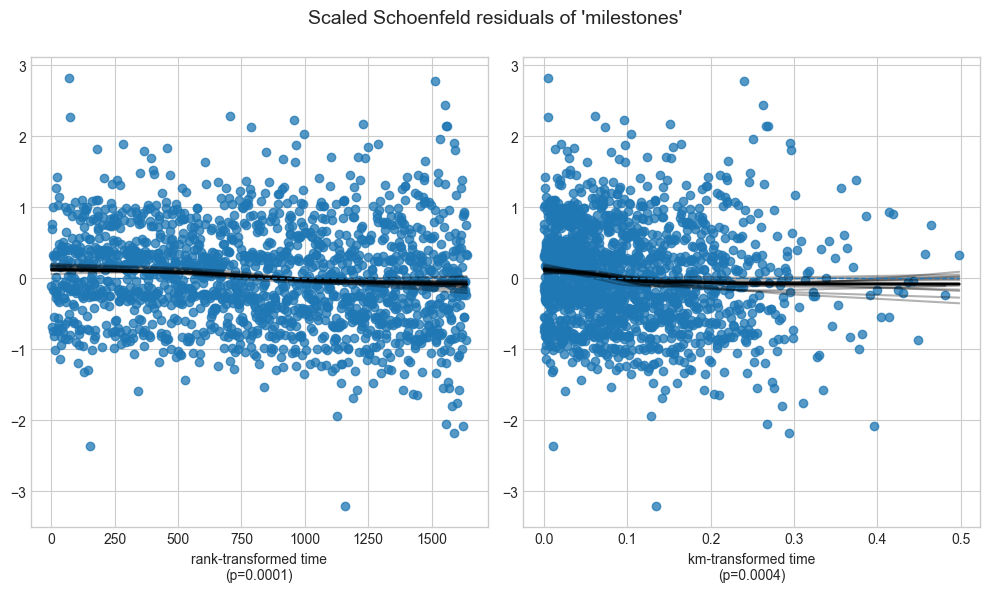

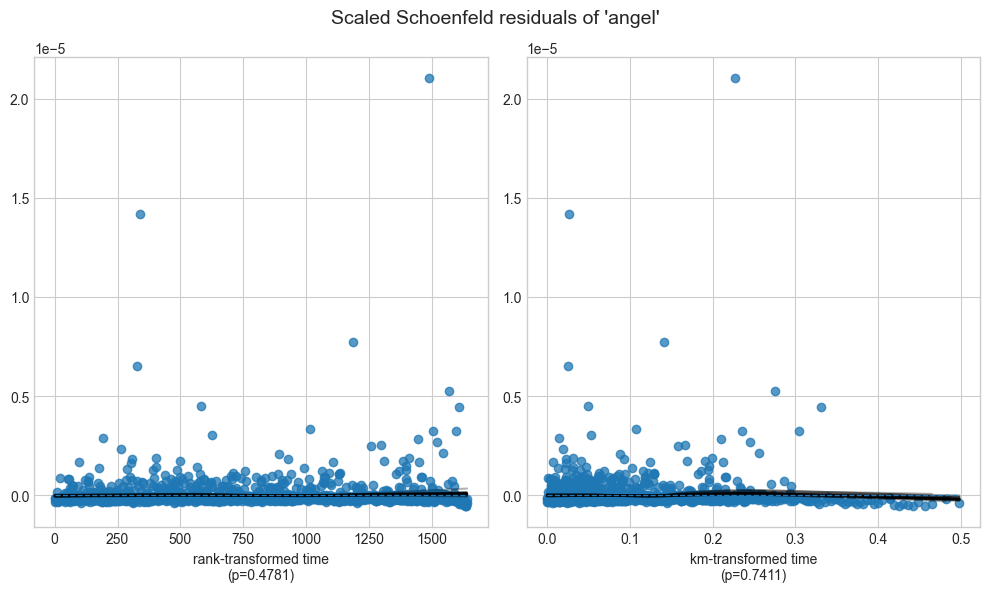

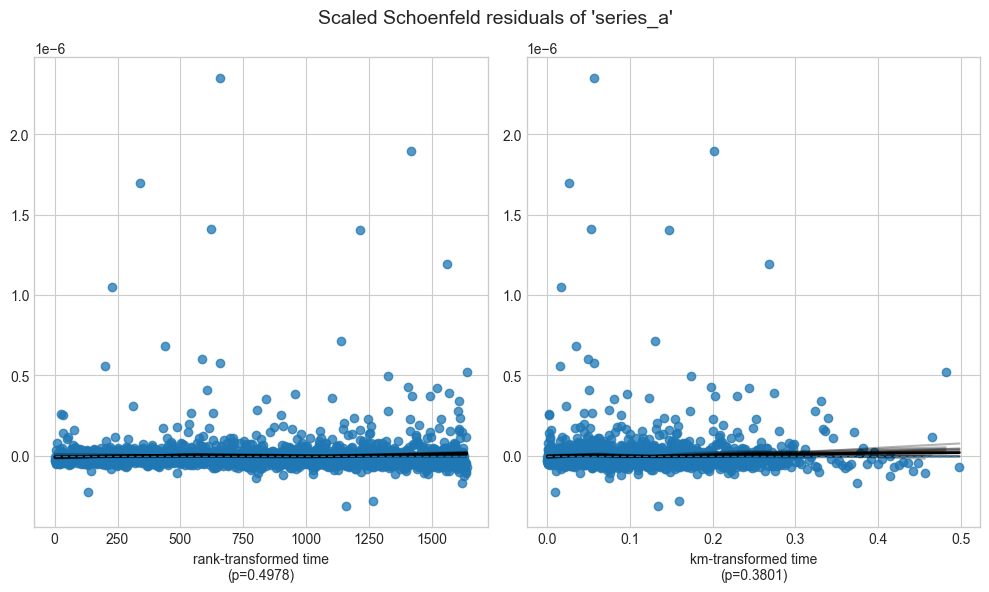

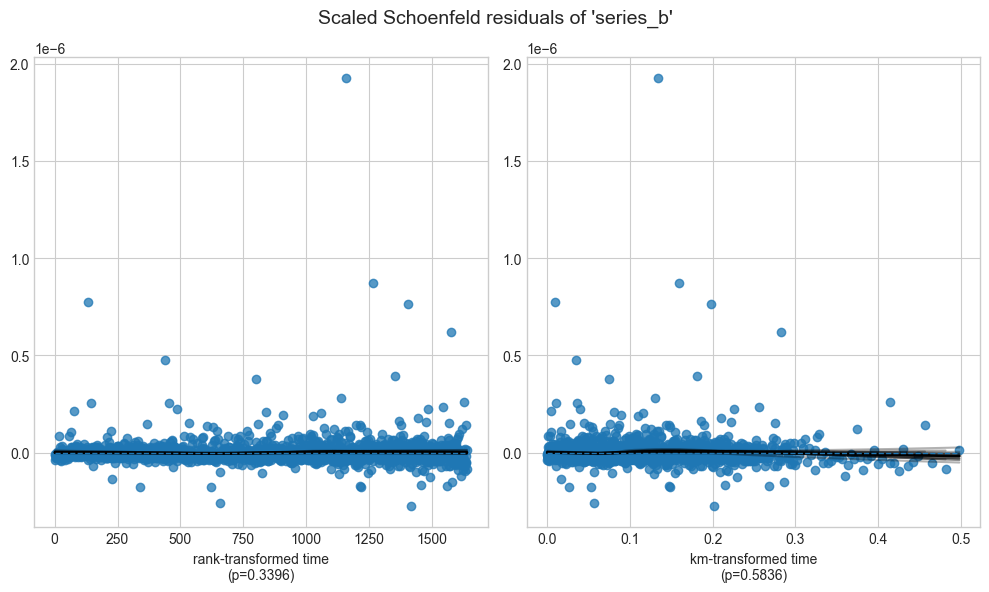

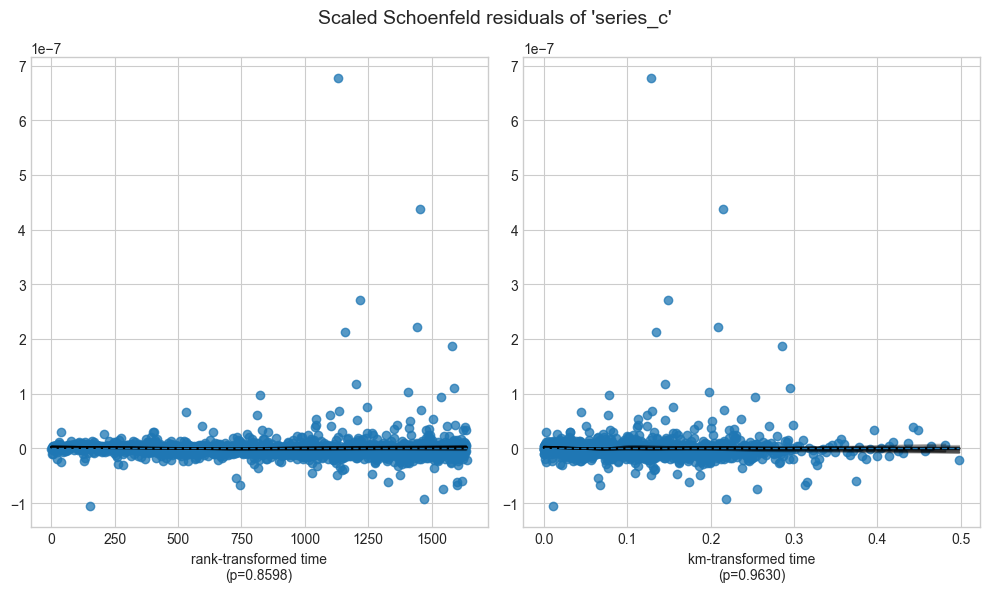

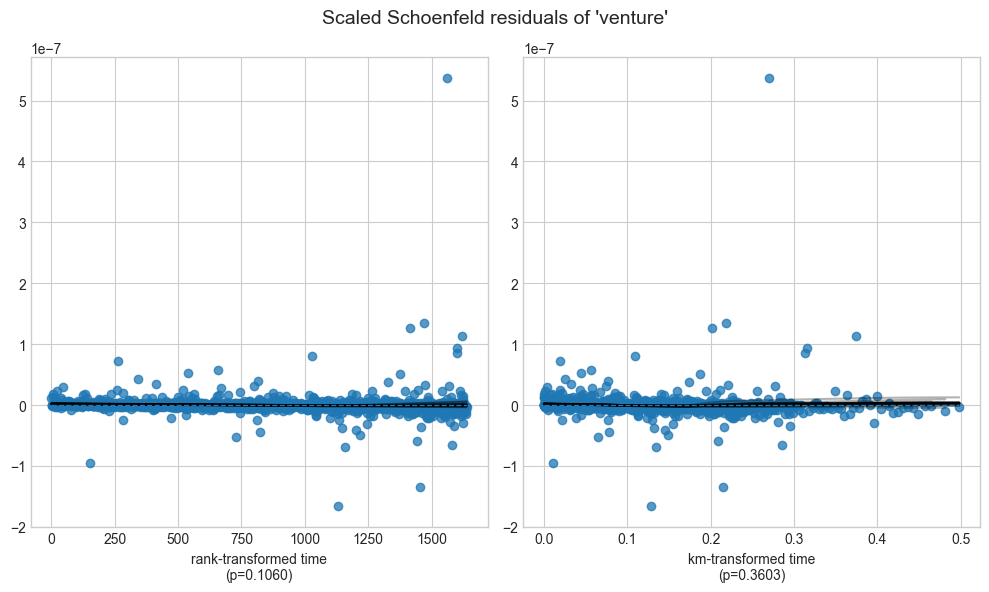

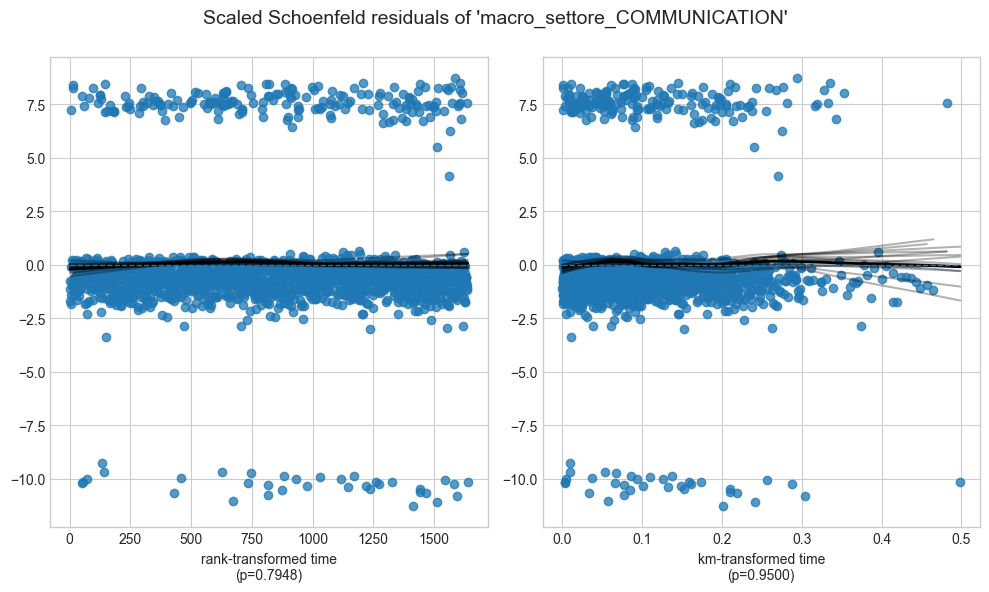

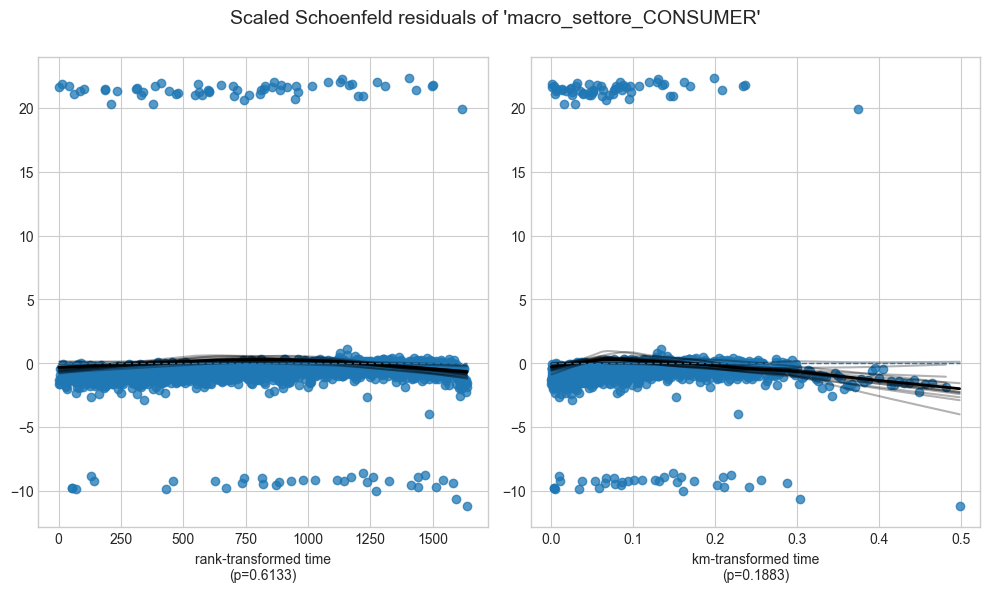

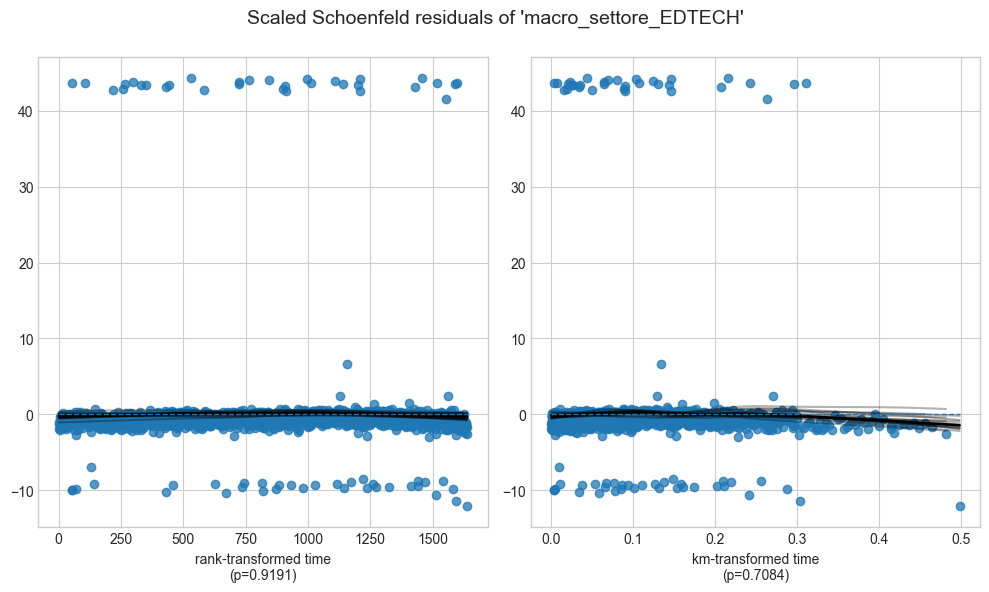

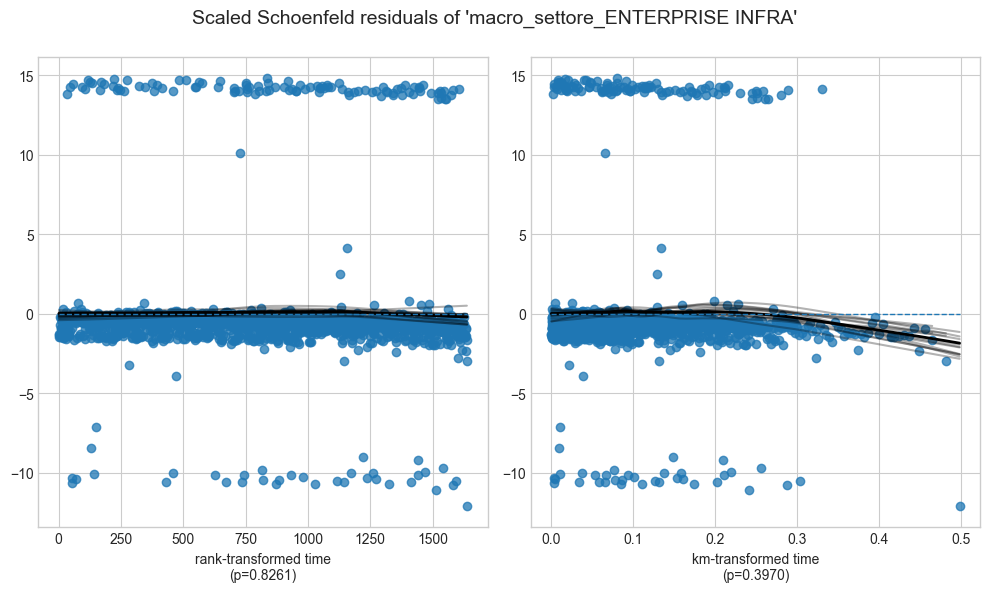

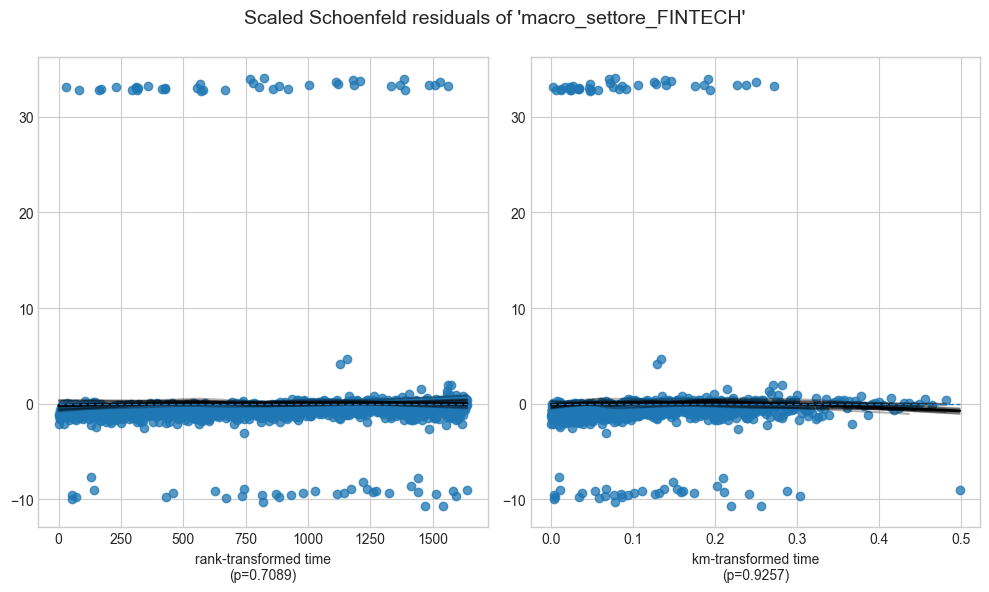

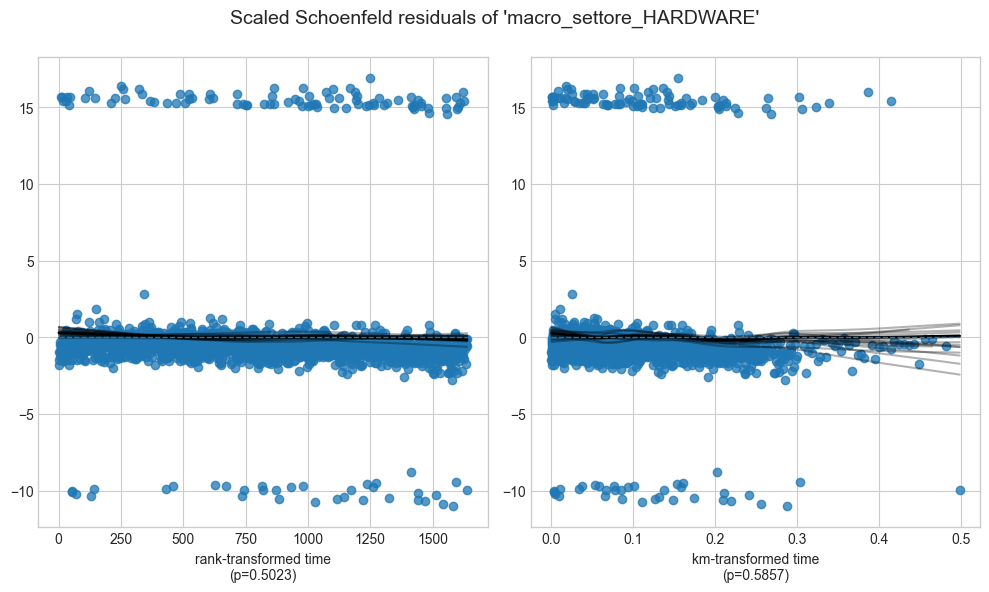

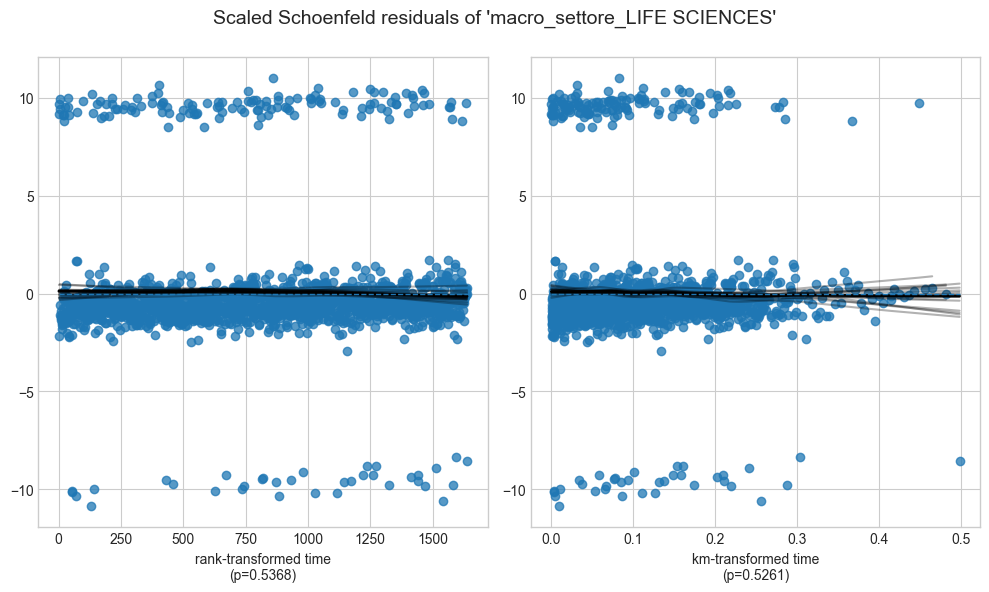

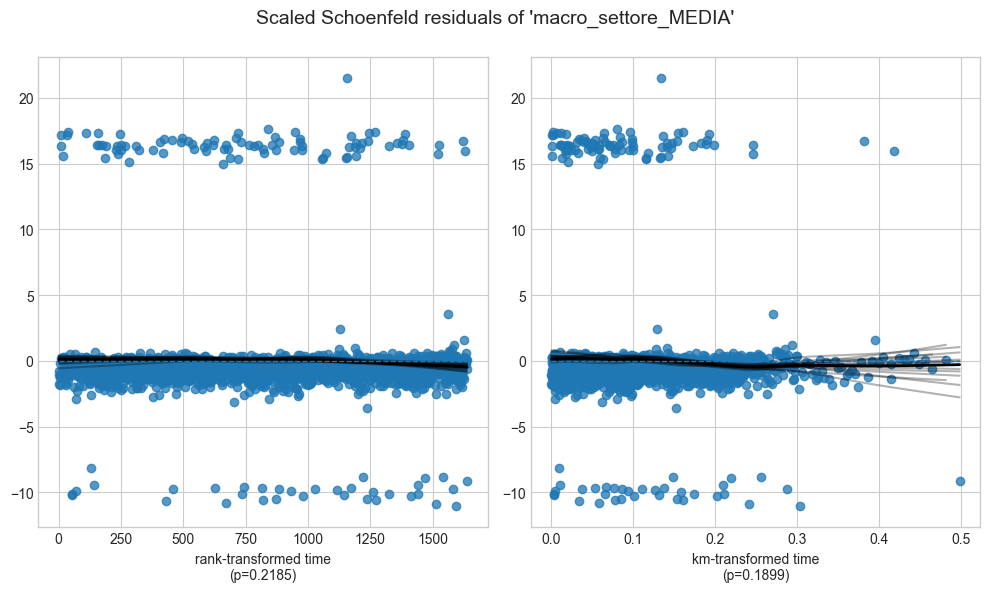

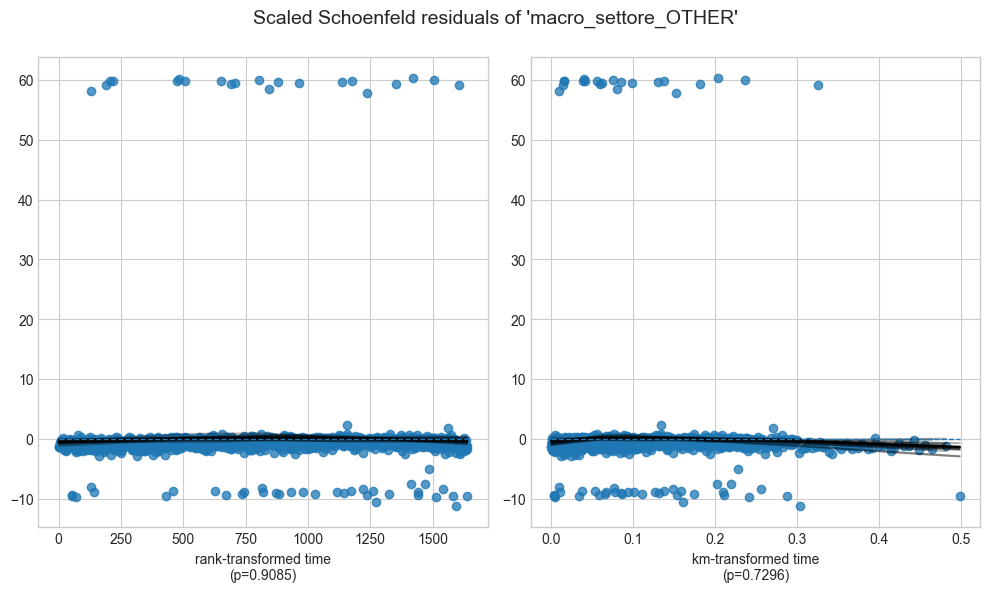

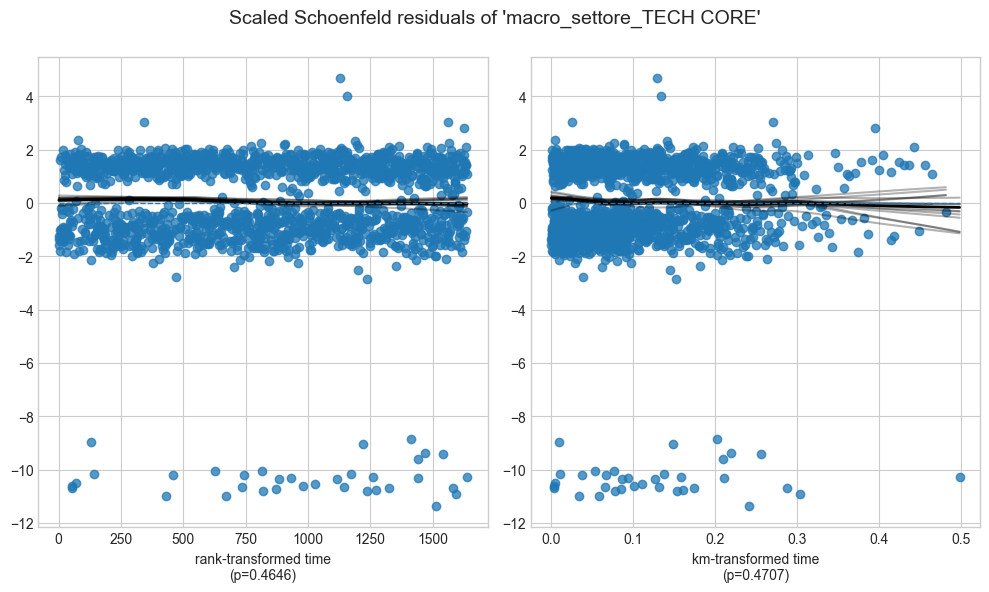

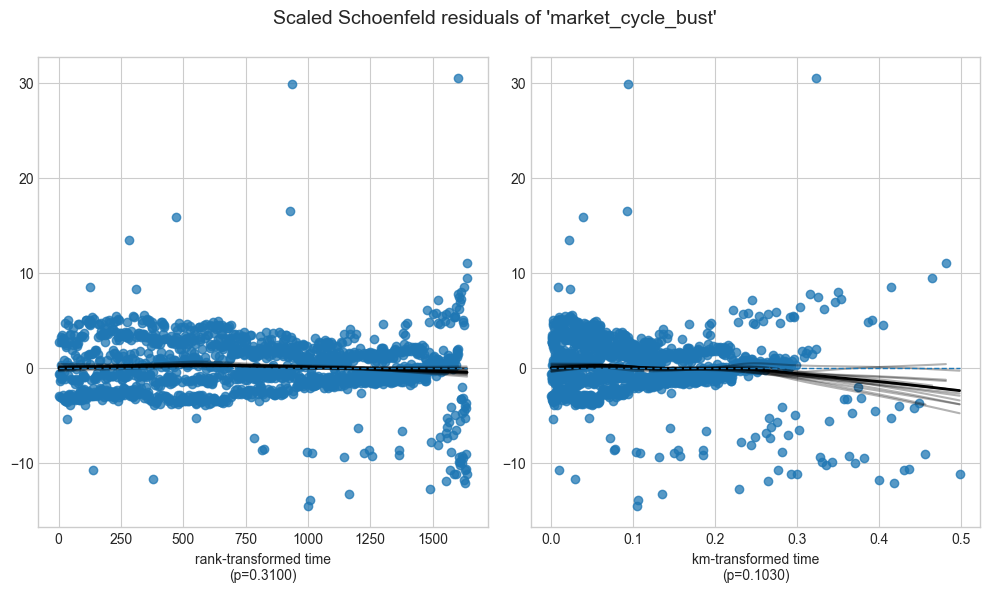

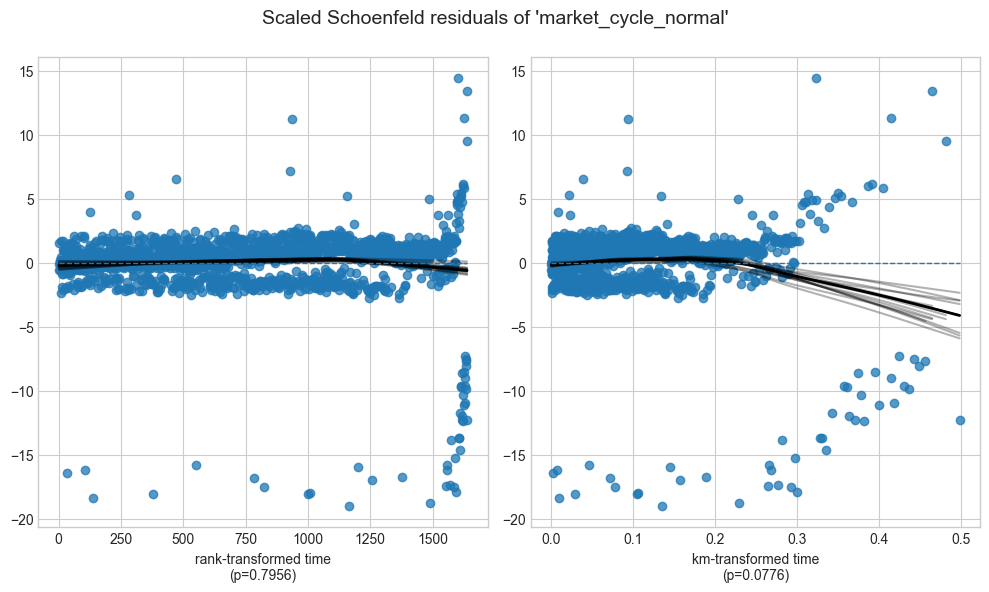

In [18]:
from lifelines.statistics import proportional_hazard_test

ph_test = proportional_hazard_test(cph, df_cox.drop(columns=['event_type']), time_transform='rank')
print("Test Proportional Hazards:")
print(ph_test.summary)

cph.check_assumptions(df_cox.drop(columns=['event_type']), p_value_threshold=0.05, show_plots=True)

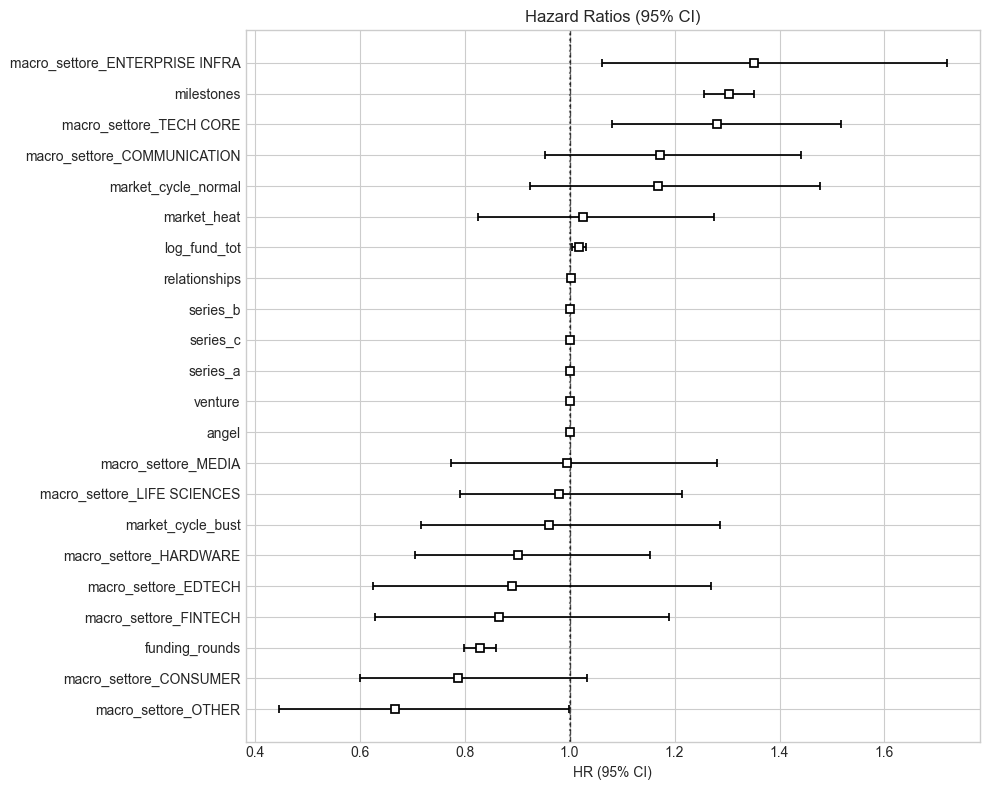

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
cph.plot(ax=ax, hazard_ratios=True)
ax.axvline(x=1, color='black', linestyle=':', alpha=0.5)
ax.set_title('Hazard Ratios (95% CI)')
plt.tight_layout()
plt.show()

In [20]:
# ========================================================================
# Cox PH Multivariate (Full Dataset) - per PH check e analisi esplorativa
# ========================================================================

print('\n' + '='*80)
print('COX PH MULTIVARIATE MODEL (FULL DATASET)')
print('='*80)

cph_full = CoxPHFitter(penalizer=0.01)
cph_full.fit(df_cox.drop(columns=[E_TYPE]), duration_col=T, event_col=E)

print(f'\nC-index (full dataset): {cph_full.concordance_index_:.4f}')
print(f'LR test p-value: {cph_full.log_likelihood_ratio_test().p_value:.2e}')

print('\nTop significant variables (p < 0.05):')
sig = cph_full.summary[cph_full.summary['p'] < 0.05][
    ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']
].round(4).head(10)
print(sig.to_string())
print('='*80)



COX PH MULTIVARIATE MODEL (FULL DATASET)

C-index (full dataset): 0.6713
LR test p-value: 2.80e-69

Top significant variables (p < 0.05):
                                exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%       p
covariate                                                                                  
log_fund_tot                       1.0178               1.0052               1.0306  0.0057
funding_rounds                     0.8290               0.7996               0.8595  0.0000
relationships                      1.0028               1.0011               1.0044  0.0010
milestones                         1.3036               1.2569               1.3520  0.0000
macro_settore_ENTERPRISE INFRA     1.3506               1.0616               1.7184  0.0144
macro_settore_OTHER                0.6676               0.4463               0.9985  0.0492
macro_settore_TECH CORE            1.2810               1.0814               1.5175  0.0042


In [21]:
# ========================================================================
# PH VIOLATIONS CHECK
# ========================================================================

print('PROPORTIONAL HAZARDS ASSUMPTIONS CHECK')

ph_results = cph_full.check_assumptions(
    df_cox.drop(columns=[E_TYPE]),
    p_value_threshold=0.05, 
    show_plots=False
)

violations = []

if hasattr(ph_results, 'summary'):
    summary_df = ph_results.summary
    for idx in summary_df.index:
        p_val = summary_df.loc[idx, 'p']
        if p_val < 0.05:
            violations.append((idx, p_val))
    
    violations.sort(key=lambda x: x[1])
    
    if violations:
        print(f"\nVariables violating PH assumption (p < 0.05):")
        print(f"\n{'Variable':<30} {'p-value':<12} {'Severity':<10}")
        print("-"*52)
        
        for var, p_val in violations:
            if p_val < 0.001:
                severity = "SEVERE"
            elif p_val < 0.01:
                severity = "MODERATE"
            else:
                severity = "MILD"
            print(f"{var:<30} {p_val:<12.4f} {severity}")
        
        print(f"IMPLICATIONS:")
        print(f"  • {len(violations)} variable(s) violate PH assumption")
        print(f"  • Cox test C-index: {ci_cox_test:.4f} (may be biased)")
        print(f"  • RSF is more reliable (no PH assumption)")
        print(f"  • Recommend: Use RSF as primary model")
    else:
        print("\nPH assumptions satisfied for all covariates (p > 0.05)")
        print(f"   Cox PH model is appropriate.")
        print(f"   Cox test C-index: {ci_cox_test:.4f}")
else:
    print("\nCould not extract PH test results")
    print("    Check the output above for details")


PROPORTIONAL HAZARDS ASSUMPTIONS CHECK
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 15304 total observations, 13666 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic      p  -log2(p)
angel                          km              0.11   0.74      0.43
                               rank            0.50   0.48      1.06
funding_rounds                 km            128.95 <0.005     96.86
                               rank          130.42 <0.005     97.93
log_fund_tot                   km              6.26   0.01      6.34
                               rank            7.81   0.01      7.59
macro_settore_COMMUNICATION    km              0.00   0.95      0.07
                               rank            0.07   0.79      0.33
macro_settore_CONSUMER         km              1.73   0.19      2.41
                               rank            0.26   0.61      0.71
macro_settore_EDTECH           km              0.14   0.71      0.50
                               rank            0.01   0.92      0.12
macro_settore_ENTERPRISE INFRA km              0.72   0.40      1.33
                               rank            0.05   0.83      0.28
macro_settore_FINTECH          km              0.01   0.93      0.11
                               rank            0.14   0.71      0.50
macro_settore_HARDWARE         km              0.30   0.59      0.77
                               rank            0.45   0.50      0.99
macro_settore_LIFE SCIENCES    km              0.40   0.53      0.93
                               rank            0.38   0.54      0.90
macro_settore_MEDIA            km              1.72   0.19      2.40
                               rank            1.51   0.22      2.19
macro_settore_OTHER            km              0.12   0.73      0.45
                               rank            0.01   0.91      0.14
macro_settore_TECH CORE        km              0.52   0.47      1.09
                               rank            0.53   0.46      1.11
market_cycle_bust              km              2.66   0.10      3.28
                               rank            1.03   0.31      1.69
market_cycle_normal            km              3.11   0.08      3.69
                               rank            0.07   0.80      0.33
market_heat                    km              0.58   0.45      1.16
                               rank            1.63   0.20      2.31
milestones                     km             12.41 <0.005     11.19
                               rank           15.31 <0.005     13.42
relationships                  km              1.27   0.26      1.94
                               rank            1.73   0.19      2.40
series_a                       km              0.77   0.38      1.40
                               rank            0.46   0.50      1.01
series_b                       km              0.30   0.58      0.78
                               rank            0.91   0.34      1.56
series_c                       km              0.00   0.96      0.05
                               rank            0.03   0.86      0.22
venture                        km              0.84   0.36      1.47
                               rank            2.61   0.11      3.24



1. Variable 'log_fund_tot' failed the non-proportional test: p-value is 0.0052.

   Advice 1: the functional form of the variable 'log_fund_tot' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'log_fund_tot' using pd.cut, and then specify it in
`strata=['log_fund_tot', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'funding_rounds' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'funding_rounds' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on

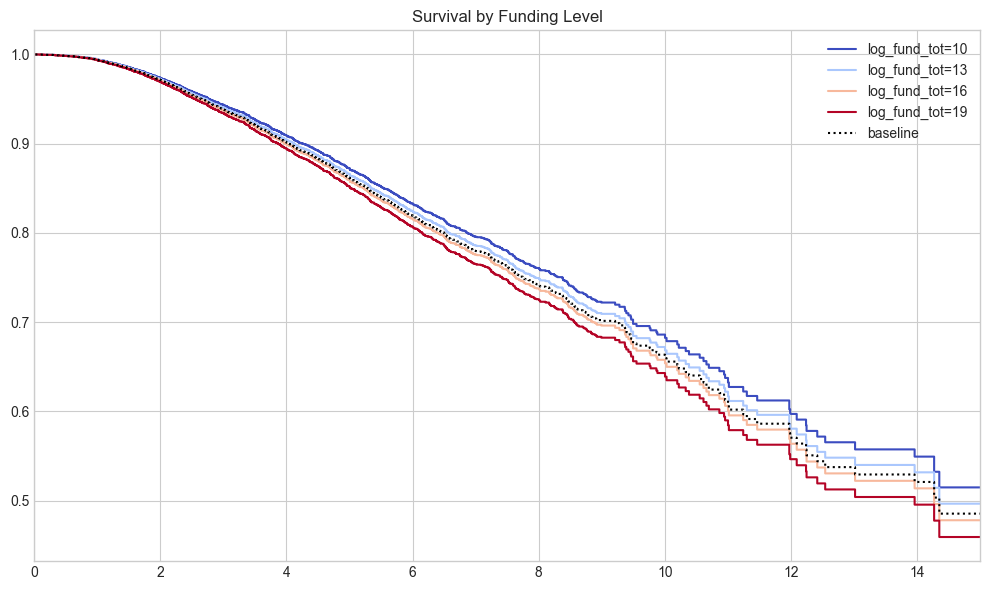

In [22]:
fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome('log_fund_tot', values=[10, 13, 16, 19], ax=ax, cmap='coolwarm')
ax.set_title('Survival by Funding Level')
ax.set_xlim(0, 15)
plt.tight_layout()
plt.show()

## 4. Competing Risks

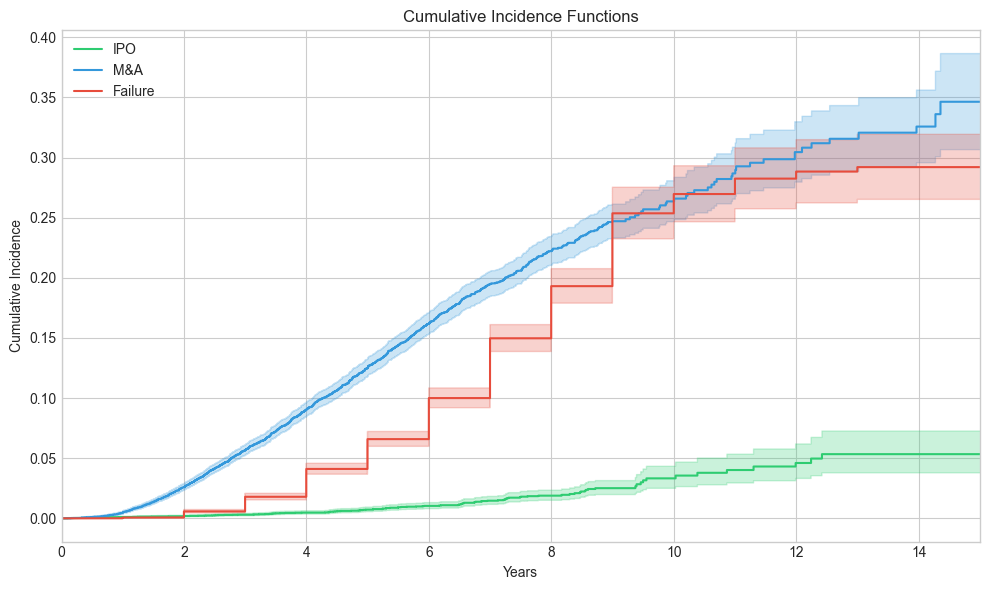

In [23]:
ajf = AalenJohansenFitter()

fig, ax = plt.subplots()
colors = {1: '#2ecc71', 2: '#3498db', 3: '#e74c3c'}
labels = {1: 'IPO', 2: 'M&A', 3: 'Failure'}

for ecode in [1, 2, 3]:
    ajf.fit(df_model[T], df_model[E_TYPE], event_of_interest=ecode)
    ajf.plot(ax=ax, label=labels[ecode], color=colors[ecode])

ax.set_xlabel('Years')
ax.set_ylabel('Cumulative Incidence')
ax.set_title('Cumulative Incidence Functions')
ax.set_xlim(0, 15)
ax.legend()
plt.tight_layout()
plt.show()

In [24]:
print('Cumulative incidence at 5 years:')
for ecode in [1, 2, 3]:
    ajf.fit(df_model[T], df_model[E_TYPE], event_of_interest=ecode)
    ci = ajf.predict(5)
    print(f'  {labels[ecode]}: {ci:.2%}')

Cumulative incidence at 5 years:
  IPO: 0.72%
  M&A: 12.53%
  Failure: 6.67%


In [25]:
print('Fine-Gray Subdistribution Hazards')

def prepare_fine_gray_data(df, event_of_interest):
    df_fg = df.copy()
    df_fg['E_cr'] = (df_fg[E_TYPE] == event_of_interest).astype(int)
    return df_fg

df_fg_ipo = prepare_fine_gray_data(df_cox, 1)
df_fg_ma = prepare_fine_gray_data(df_cox, 2)
df_fg_fail = prepare_fine_gray_data(df_cox, 3)

feat_cols = [c for c in df_cox.columns if c not in [T, E, E_TYPE]]

print('IPO Subdistribution Model:')
cph_ipo_sub = CoxPHFitter(penalizer=0.01)
cph_ipo_sub.fit(df_fg_ipo[feat_cols + [T, 'E_cr']], duration_col=T, event_col='E_cr')
print(f'C-index: {cph_ipo_sub.concordance_index_:.4f}')
print(cph_ipo_sub.summary[cph_ipo_sub.summary['p'] < 0.05][['exp(coef)', 'p']].head())

print('\nM&A Subdistribution Model:')
cph_ma_sub = CoxPHFitter(penalizer=0.01)
cph_ma_sub.fit(df_fg_ma[feat_cols + [T, 'E_cr']], duration_col=T, event_col='E_cr')
print(f'C-index: {cph_ma_sub.concordance_index_:.4f}')
print(cph_ma_sub.summary[cph_ma_sub.summary['p'] < 0.05][['exp(coef)', 'p']].head())

print('\nFailure Subdistribution Model:')
cph_fail_sub = CoxPHFitter(penalizer=0.01)
cph_fail_sub.fit(df_fg_fail[feat_cols + [T, 'E_cr']], duration_col=T, event_col='E_cr')
print(f'C-index: {cph_fail_sub.concordance_index_:.4f}')
print(cph_fail_sub.summary[cph_fail_sub.summary['p'] < 0.05][['exp(coef)', 'p']].head())

Fine-Gray Subdistribution Hazards
IPO Subdistribution Model:
C-index: 0.7630
                exp(coef)             p
covariate                              
log_fund_tot     1.038057  2.020865e-02
funding_rounds   1.079869  2.729730e-02
relationships    1.006759  9.655694e-19
milestones       1.215013  5.158559e-05
series_a         1.000000  1.593700e-02

M&A Subdistribution Model:
C-index: 0.6847
                                exp(coef)             p
covariate                                              
log_fund_tot                     1.020881  1.825881e-03
funding_rounds                   0.819543  8.039178e-22
relationships                    0.992333  1.833921e-02
milestones                       1.328610  4.208473e-45
macro_settore_ENTERPRISE INFRA   1.398280  8.095022e-03

Failure Subdistribution Model:
C-index: 0.8004
                exp(coef)             p
covariate                              
log_fund_tot     0.959403  1.709530e-11
funding_rounds   0.786682  1.300528e-14

In [26]:
def cause_specific_cox(data, cause, feat_cols):
    df_c = data.copy()
    df_c['e_cause'] = (df_c[E_TYPE] == cause).astype(int)
    df_c = df_c[df_c[E_TYPE].isin([0, cause])]
    
    cph_c = CoxPHFitter(penalizer=0.01)
    cph_c.fit(df_c[feat_cols + [T, 'e_cause']], duration_col=T, event_col='e_cause')
    return cph_c

feat_cols = [c for c in df_cox.columns if c not in [T, E, E_TYPE]]
df_cr = df_cox.copy()
df_cr[E_TYPE] = df_model[E_TYPE]

In [27]:
cph_ipo = cause_specific_cox(df_cr, 1, feat_cols)
print(f'IPO model C-index: {cph_ipo.concordance_index_:.4f}')
print(cph_ipo.summary[cph_ipo.summary['p'] < 0.1][['exp(coef)', 'p']].round(4).head(8).to_string())

IPO model C-index: 0.7640
                             exp(coef)       p
covariate                                     
log_fund_tot                    1.0438  0.0147
funding_rounds                  1.0682  0.0648
relationships                   1.0062  0.0000
milestones                      1.2459  0.0000
series_a                        1.0000  0.0114
series_b                        1.0000  0.0058
series_c                        1.0000  0.0004
macro_settore_LIFE SCIENCES     1.7797  0.0011


In [28]:
cph_ma = cause_specific_cox(df_cr, 2, feat_cols)
print(f'M&A model C-index: {cph_ma.concordance_index_:.4f}')
print(cph_ma.summary[cph_ma.summary['p'] < 0.05][['exp(coef)', 'p']].round(4).head(8).to_string())

M&A model C-index: 0.6916
                                exp(coef)       p
covariate                                        
log_fund_tot                       1.0161  0.0165
funding_rounds                     0.8073  0.0000
relationships                      0.9876  0.0014
milestones                         1.3366  0.0000
macro_settore_COMMUNICATION        1.2513  0.0422
macro_settore_ENTERPRISE INFRA     1.4005  0.0085
macro_settore_TECH CORE            1.3537  0.0008


In [29]:
cph_fail = cause_specific_cox(df_cr, 3, feat_cols)
print(f'Failure model C-index: {cph_fail.concordance_index_:.4f}')
print(cph_fail.summary[cph_fail.summary['p'] < 0.05][['exp(coef)', 'p']].round(4).head(8).to_string())

Failure model C-index: 0.7910
                        exp(coef)       p
covariate                                
log_fund_tot               0.9631  0.0000
funding_rounds             0.8116  0.0000
market_heat                0.1816  0.0000
relationships              0.9227  0.0000
angel                      1.0000  0.0293
series_c                   1.0000  0.0478
venture                    1.0000  0.0162
macro_settore_CONSUMER     1.3802  0.0249


In [30]:
compare_feats = ['log_fund_tot', 'funding_rounds', 'market_heat', 'relationships', 'milestones']
comp_data = []

for f in compare_feats:
    row = {'Feature': f}
    for model, name in [(cph_ipo, 'IPO'), (cph_ma, 'M&A'), (cph_fail, 'Fail')]:
        if f in model.summary.index:
            row[name] = model.summary.loc[f, 'exp(coef)']
    comp_data.append(row)

print('HR comparison by outcome:')
print(pd.DataFrame(comp_data).round(3).to_string(index=False))

HR comparison by outcome:
       Feature   IPO   M&A  Fail
  log_fund_tot 1.044 1.016 0.963
funding_rounds 1.068 0.807 0.812
   market_heat 1.368 1.082 0.182
 relationships 1.006 0.988 0.923
    milestones 1.246 1.337 1.061


## 5. Machine Learning: Survival

In [31]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sksurv.metrics import concordance_index_censored

# Prepare survival data
y_surv_train = Surv.from_dataframe(E, T, df_cox.loc[train_idx])
y_surv_test = Surv.from_dataframe(E, T, df_cox.loc[test_idx])

print(f'Train: {len(train_idx)}, Test: {len(test_idx)}')
print(f'Event rate: train={y_e_train.mean():.2%}, test={y_e_test.mean():.2%}')

# Scorer function
def rsf_scorer(estimator, X, y):
    return estimator.score(X, y)


Train: 12243, Test: 3061
Event rate: train=10.70%, test=10.72%


In [32]:
# Define parameter grid
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 8],
    'min_samples_split': [50, 100],
    'min_samples_leaf': [30, 50],
    'max_features': ['sqrt'] 
}

# Base RSF
rsf_base = RandomSurvivalForest(random_state=SEED, n_jobs=-1)

# Grid search with 3-fold CV
grid_search = GridSearchCV(
    rsf_base,
    param_grid,
    cv=3,
    scoring=rsf_scorer,
    n_jobs=-1,
    verbose=2
)

print('Fitting grid search')
grid_search.fit(X_train_scaled, y_surv_train)

print(f'\nBest parameters found:')
for param, value in grid_search.best_params_.items():
    print(f'{param}: {value}')
print(f'Best CV score: {grid_search.best_score_:.4f}')

# Use best model
rsf = grid_search.best_estimator_

Fitting grid search
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=200; total time= 4.2min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=200; total time= 4.6min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=200; total time= 4.6min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=200; total time= 4.8min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=200; total time= 4.8min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=300; total time= 5.0min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=300; total time= 5.0min
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=30, min_samp

Python(33444) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, n_estimators=200; total time=  29.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, n_estimators=200; total time=  29.2s


Python(33481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, n_estimators=300; total time=  36.2s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=200; total time=  32.6s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=200; total time=  39.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, n_estimators=300; total time=  49.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, n_estimators=300; total time=  46.0s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=200; total time=  36.5s


Python(33609) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=300; total time=  42.8s


Python(33631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=200; total time=  28.6s
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=200; total time= 6.4min
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=300; total time= 6.8min
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=200; total time= 6.8min
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=50, n_estimators=300; total time= 7.5min
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=200; total time=27.2min
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=100, n_estimators=300; total time=27.7min
[CV] END max_depth=8, max_features=sqrt, min_samples_leaf=50, min_samples_split=100, n_estimators=200; total time=  26.4s
[CV] END max_depth=8, max_f

In [33]:
print('RSF PERFORMANCE (TUNED MODEL)')

# Train/Test C-index
ci_rsf_train = rsf.score(X_train_scaled, y_surv_train)
ci_rsf_test = rsf.score(X_test_scaled, y_surv_test)

print(f'\nC-index:')
print(f'  Train: {ci_rsf_train:.4f}')
print(f'  Test:  {ci_rsf_test:.4f}')
print(f'  Overfit gap: {ci_rsf_train - ci_rsf_test:+.4f} ({(ci_rsf_train - ci_rsf_test)*100:+.2f}%)')

# Cross-validation scores
cv_scores = cross_val_score(
    rsf, X_train_scaled, y_surv_train,
    cv=5,
    scoring=rsf_scorer,
    n_jobs=-1
)

print(f'\n5-Fold CV scores: {cv_scores}')
print(f'CV Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'CV vs Test gap: {(cv_scores.mean() - ci_rsf_test)*100:+.2f}%')


RSF PERFORMANCE (TUNED MODEL)

C-index:
  Train: 0.7684
  Test:  0.6856
  Overfit gap: +0.0828 (+8.28%)


Python(39639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(39640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



5-Fold CV scores: [0.70643745 0.70997593 0.71864739 0.70835255 0.72631259]
CV Mean: 0.7139 ± 0.0075
CV vs Test gap: +2.84%


Integrated Brier Score: 0.0859
Mean Brier Score: 0.0747
Brier at each time:
  1.3 years: 0.0145
  1.9 years: 0.0254
  2.4 years: 0.0392
  2.9 years: 0.0514
  3.5 years: 0.0619
  4.1 years: 0.0814
  4.9 years: 0.1091
  5.8 years: 0.1308
  7.0 years: 0.1586


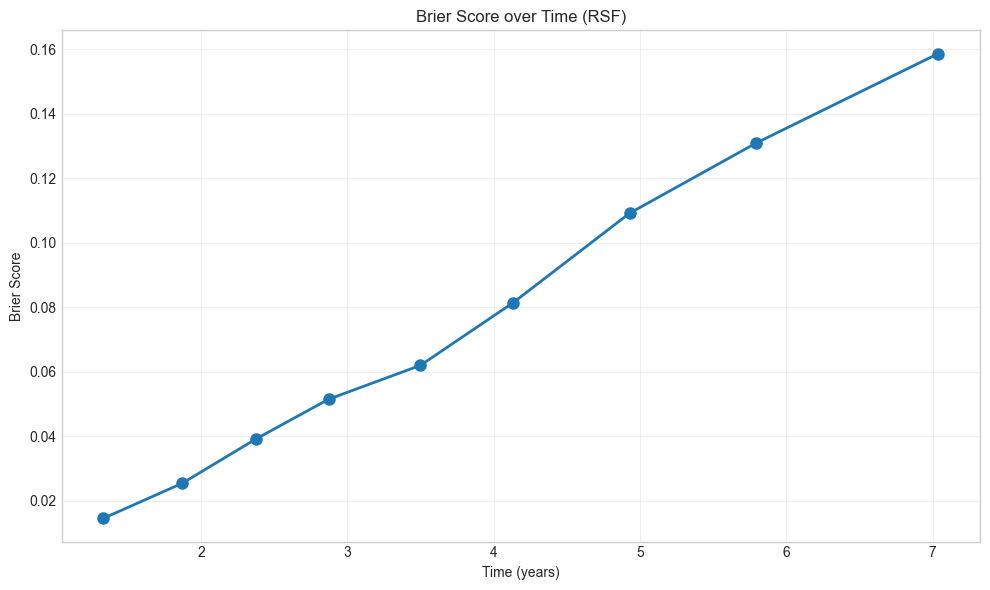

In [34]:
# %%
from sksurv.metrics import brier_score

times = np.percentile(df_cox[df_cox[E] == 1][T], np.linspace(10, 90, 9))
max_time = min(y_surv_test['duration_years'].max(), rsf.unique_times_.max())
times = times[times < max_time]

surv_funcs_full = rsf.predict_survival_function(X_test_scaled, return_array=True)

surv_funcs_at_times = np.zeros((len(X_test_scaled), len(times)))
for i, t in enumerate(times):
    time_idx = np.searchsorted(rsf.unique_times_, t)
    if time_idx >= len(rsf.unique_times_):
        time_idx = len(rsf.unique_times_) - 1
    surv_funcs_at_times[:, i] = surv_funcs_full[:, time_idx]

brier_scores = []
for i, t in enumerate(times):
    _, bs = brier_score(y_surv_train, y_surv_test, surv_funcs_at_times[:, i], t)
    brier_scores.append(bs[0])

ibs = np.trapezoid(brier_scores, times) / (times[-1] - times[0])

print(f'Integrated Brier Score: {ibs:.4f}')
print(f'Mean Brier Score: {np.mean(brier_scores):.4f}')
print(f'Brier at each time:')
for t, bs in zip(times, brier_scores):
    print(f'  {t:.1f} years: {bs:.4f}')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(times, brier_scores, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Brier Score')
ax.set_title('Brier Score over Time (RSF)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


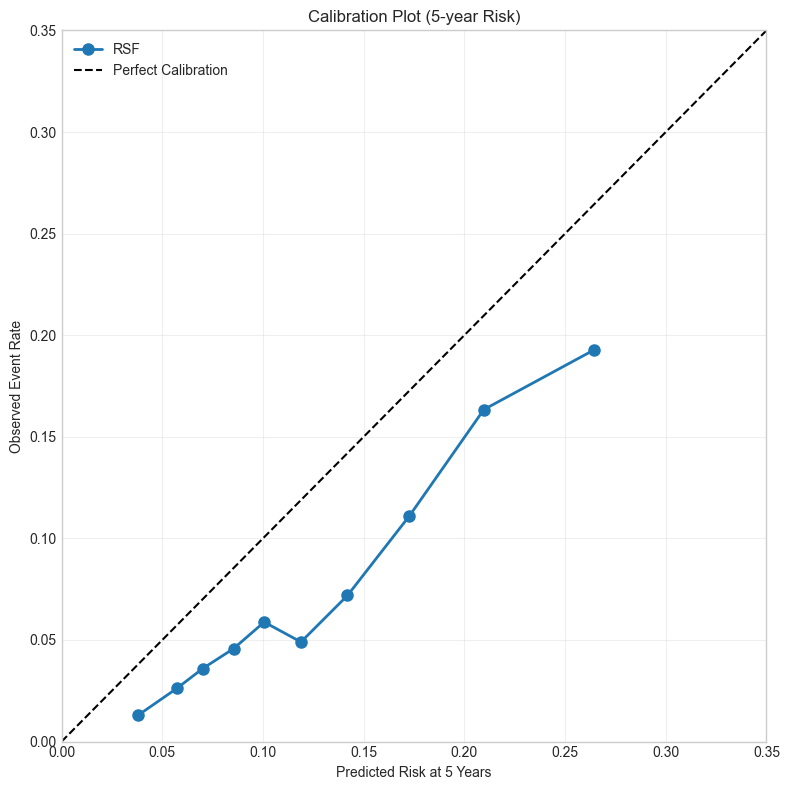

Mean absolute calibration error: 0.0491
Bins: 10


In [35]:
from sklearn.calibration import calibration_curve

t_eval = 5
time_idx_5y = np.searchsorted(rsf.unique_times_, t_eval)
if time_idx_5y >= len(rsf.unique_times_):
    time_idx_5y = len(rsf.unique_times_) - 1

surv_funcs_full = rsf.predict_survival_function(X_test_scaled, return_array=True)
risk_pred_5y = 1 - surv_funcs_full[:, time_idx_5y]
y_obs_5y = (y_surv_test['duration_years'] <= t_eval) & (y_surv_test['event'])

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_obs_5y, risk_pred_5y, n_bins=10, strategy='quantile'
)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(mean_predicted_value, fraction_of_positives, 'o-', linewidth=2, 
        markersize=8, label='RSF')
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax.set_xlabel('Predicted Risk at 5 Years')
ax.set_ylabel('Observed Event Rate')
ax.set_title('Calibration Plot (5-year Risk)')
ax.legend()
ax.set_xlim(0, 0.35)
ax.set_ylim(0, 0.35)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Mean absolute calibration error: {np.mean(np.abs(fraction_of_positives - mean_predicted_value)):.4f}')
print(f'Bins: {len(fraction_of_positives)}')


Time-Dependent AUC (C-index):
  1 year(s): 0.5726
  3 year(s): 0.6896
  5 year(s): 0.6440
  10 year(s): 0.5820
Mean: 0.6221


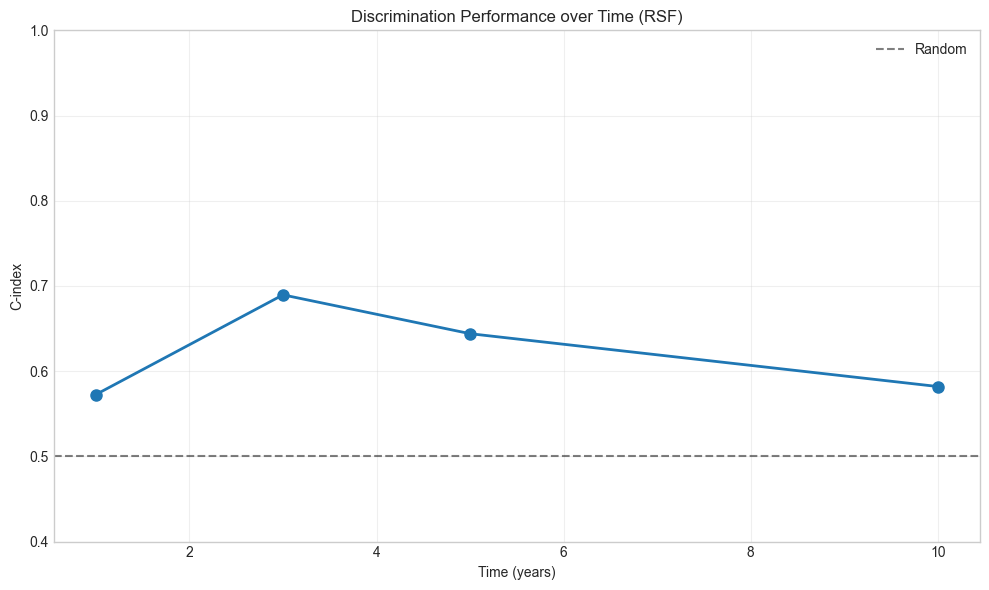

In [36]:
from sksurv.metrics import concordance_index_censored

times_eval = np.array([1, 3, 5, 10])

risk_test = rsf.predict(X_test_scaled)

auc_scores = []
for t in times_eval:
    mask = (y_surv_test['duration_years'] >= t) | (y_surv_test['event'] == True)
    if mask.sum() < 10:
        auc_scores.append(np.nan)
        continue
    
    y_test_t = y_surv_test[mask]
    risk_t = risk_test[mask]
    
    event_t = (y_test_t['duration_years'] <= t) & (y_test_t['event'] == True)
    
    try:
        ci, _, _, _, _ = concordance_index_censored(event_t, y_test_t['duration_years'], risk_t)
        auc_scores.append(ci)
    except:
        auc_scores.append(np.nan)

auc_scores = np.array(auc_scores)
mean_auc = np.nanmean(auc_scores)

print('Time-Dependent AUC (C-index):')
for t, auc in zip(times_eval, auc_scores):
    print(f'  {t} year(s): {auc:.4f}')
print(f'Mean: {mean_auc:.4f}')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(times_eval, auc_scores, 'o-', linewidth=2, markersize=8)
ax.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Random')
ax.set_xlabel('Time (years)')
ax.set_ylabel('C-index')
ax.set_title('Discrimination Performance over Time (RSF)')
ax.set_ylim([0.4, 1.0])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


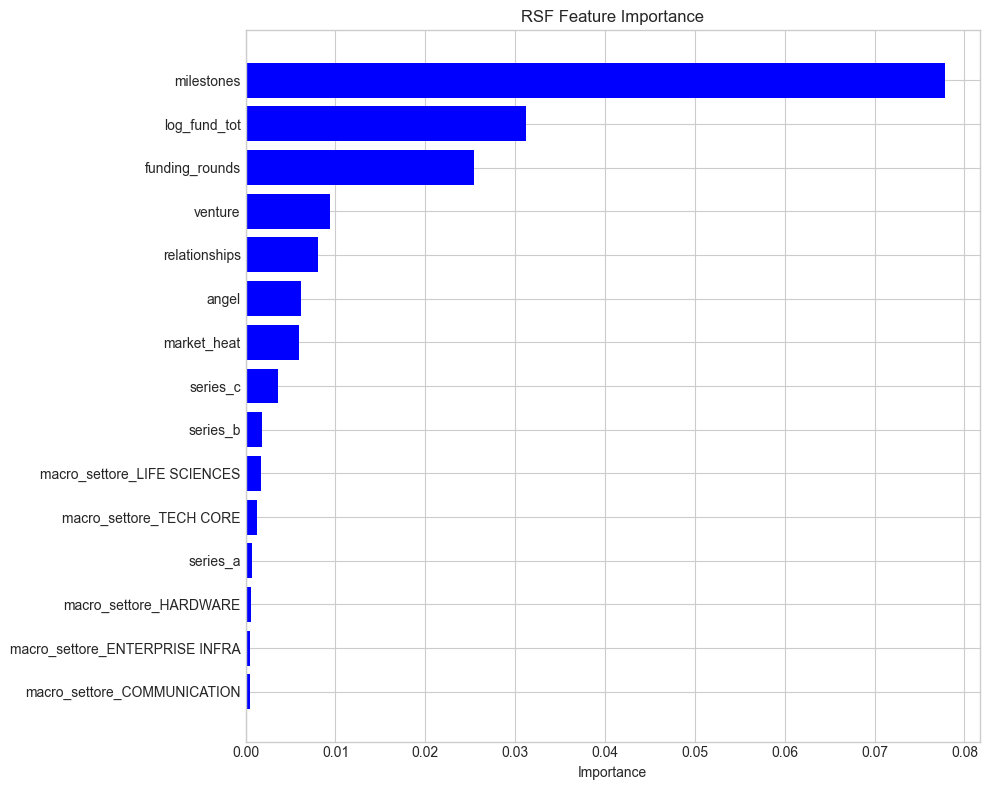

In [37]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    rsf, 
    X_test_scaled,
    y_surv_test,
    n_repeats=10, 
    random_state=SEED, 
    n_jobs=1
)

rsf_imp = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'Importance': perm_importance.importances_mean
})
rsf_imp = rsf_imp.sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
top = rsf_imp.head(15)
ax.barh(range(len(top)), top['Importance'].values, color='blue')
ax.set_yticks(range(len(top)))
ax.set_yticklabels(top['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('RSF Feature Importance')
plt.tight_layout()
plt.show()


Python(41410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


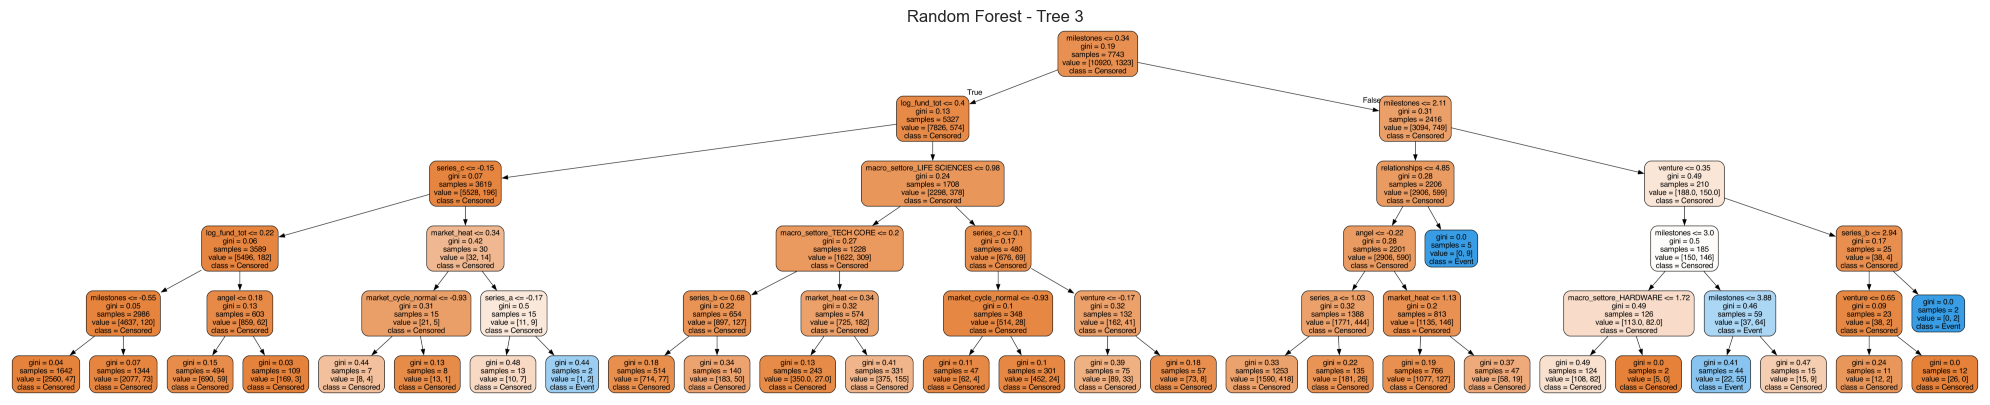

Saved to: /Users/danieleparini/Desktop/advanced-data-analysis-project/models/tree.png


In [38]:
from sklearn.tree import export_graphviz
from subprocess import call
import matplotlib.image
from pathlib import Path

rf_for_tree = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=SEED, n_jobs=-1)
rf_for_tree.fit(X_train_scaled, y_e_train)

tree_idx = 3
estimator = rf_for_tree.estimators_[tree_idx]

dot_file = config.OUTPUT_PATH / 'tree.dot'
png_file = config.OUTPUT_PATH / 'tree.png'

export_graphviz(estimator, 
                out_file=str(dot_file),
                feature_names=X_train_scaled.columns.tolist(),
                class_names=['Censored', 'Event'],
                rounded=True, 
                proportion=False,
                precision=2, 
                filled=True)

call(['dot', '-Tpng', str(dot_file), '-o', str(png_file), '-Gdpi=600'])

img = matplotlib.image.imread(str(png_file))
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.title(f'Random Forest - Tree {tree_idx}')
plt.tight_layout()
plt.show()

print(f'Saved to: {png_file}')

Bootstrap Confidence Intervals
Sample 0 - 5-year Risk:
Point estimate: 0.073
95% CI: [0.053, 0.097]


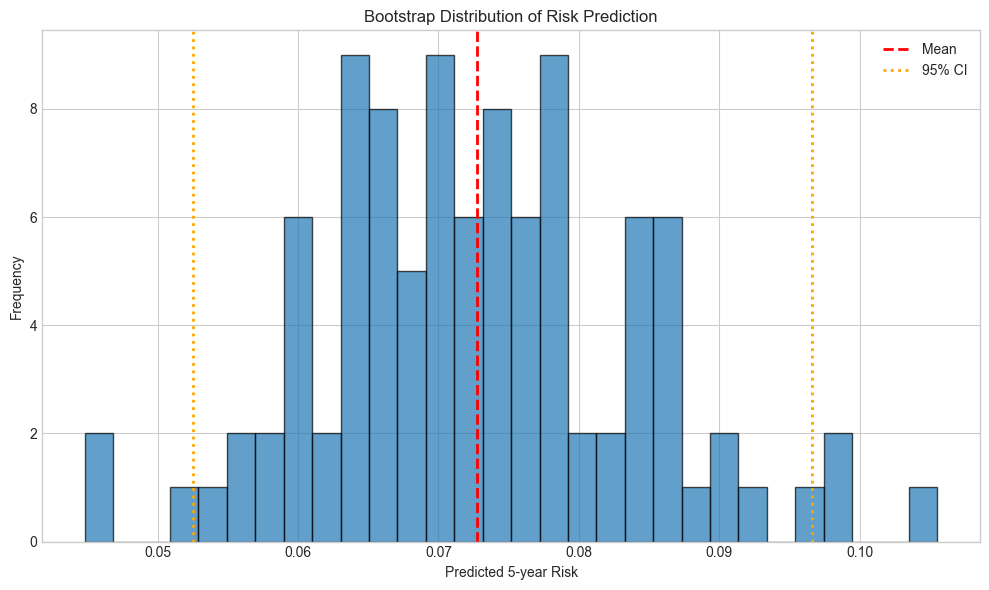

In [39]:
print('Bootstrap Confidence Intervals')

n_bootstrap = 100
bootstrap_preds = []

sample_idx = 0
X_sample = X_test_scaled.iloc[[sample_idx]]

for i in range(n_bootstrap):
    idx = np.random.choice(len(X_train_scaled), len(X_train_scaled), replace=True)
    X_boot = X_train_scaled.iloc[idx]
    y_boot = y_surv_train[idx]
    
    rsf_boot = RandomSurvivalForest(
        n_estimators=50, 
        max_depth=5,
        random_state=i,
        n_jobs=-1
    )
    rsf_boot.fit(X_boot, y_boot)
    
    surv = rsf_boot.predict_survival_function(X_sample, return_array=True)
    time_idx = np.searchsorted(rsf_boot.unique_times_, 5)
    time_idx = min(time_idx, len(rsf_boot.unique_times_) - 1)
    risk = 1 - surv[0, time_idx]
    bootstrap_preds.append(risk)

pred_mean = np.mean(bootstrap_preds)
pred_ci = np.percentile(bootstrap_preds, [2.5, 97.5])

print(f'Sample {sample_idx} - 5-year Risk:')
print(f'Point estimate: {pred_mean:.3f}')
print(f'95% CI: [{pred_ci[0]:.3f}, {pred_ci[1]:.3f}]')

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(bootstrap_preds, bins=30, alpha=0.7, edgecolor='black')
ax.axvline(pred_mean, color='red', linestyle='--', linewidth=2, label='Mean')
ax.axvline(pred_ci[0], color='orange', linestyle=':', linewidth=2, label='95% CI')
ax.axvline(pred_ci[1], color='orange', linestyle=':', linewidth=2)
ax.set_xlabel('Predicted 5-year Risk')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution of Risk Prediction')
ax.legend()
plt.tight_layout()
plt.show()


In [16]:
try:
    from xgbse import XGBSEKaplanNeighbors
    from xgbse.converters import convert_to_structured
    
    y_train_xgb = convert_to_structured(df_cox.loc[train_idx, T], df_cox.loc[train_idx, E])
    y_test_xgb = convert_to_structured(df_cox.loc[test_idx, T], df_cox.loc[test_idx, E])
    
    xgbse = XGBSEKaplanNeighbors(
        n_neighbors=50,
        xgb_params={
            'objective': 'survival:aft',
            'eval_metric': 'aft-nloglik',
            'aft_loss_distribution': 'normal',
            'max_depth': 5,
            'learning_rate': 0.01,
            'n_estimators': 500,
            'subsample': 0.8,
            'colsample_bytree': 0.8,  
            'random_state': SEED,
            'n_jobs': -1  
        }
    )
    
    xgbse.fit(
        X_train_scaled,
        y_train_xgb,
        num_boost_round=100,
        validation_data=(X_test_scaled, y_test_xgb),
        early_stopping_rounds=20,
        verbose_eval=False
    )
    
    risk_train = -xgbse.predict(X_train_scaled).mean(axis=1)
    
    ci_xgb_train = concordance_index_censored(
        y_train_xgb[y_train_xgb.dtype.names[0]],
        y_train_xgb[y_train_xgb.dtype.names[1]],
        risk_train
    )[0]


    risk_test = -xgbse.predict(X_test_scaled).mean(axis=1)

    ci_xgb_test = concordance_index_censored(
        y_test_xgb[y_test_xgb.dtype.names[0]],
        y_test_xgb[y_test_xgb.dtype.names[1]],
        risk_test
    )[0]
    
    print(f'\nXGBSE C-index: train={ci_xgb_train:.4f}')
    print(f'XGBSE C-index: test={ci_xgb_test:.4f}')
    
except ImportError:
    print('XGBSE not installed, skipping')
    ci_xgb_test = None
except Exception as e:
    print(f'XGBSE error: {e}')
    import traceback
    traceback.print_exc()
    ci_xgb_test = None


XGBSE C-index: train=0.7134
XGBSE C-index: test=0.6392


In [ ]:
# ========================================================================
# Model Comparison (C-index)
# ========================================================================

print('MODEL COMPARISON (C-INDEX)')

print(f'\n{"Model":<15} {"Train":>8} {"Test":>8} {"Overfit":>8}')

# Cox PH
print(f'{"Cox PH":<15} {ci_cox_train:>8.4f} {ci_cox_test:>8.4f} {ci_cox_train-ci_cox_test:>+8.4f}')

# RSF
print(f'{"RSF":<15} {ci_rsf_train:>8.4f} {ci_rsf_test:>8.4f} {ci_rsf_train-ci_rsf_test:>+8.4f}')

# XGBSE
if 'ci_xgb_test' in locals() and ci_xgb_test is not None:
    print(f'{"XGBSE":<15} {ci_xgb_train:>8.4f} {ci_xgb_test:>8.4f} {ci_xgb_train-ci_xgb_test:>+8.4f}')

# Best model
models = [
    ('Cox PH', ci_cox_test),
    ('RSF', ci_rsf_test),
]
if 'ci_xgb_test' in locals() and ci_xgb_test is not None:
    models.append(('XGBSE', ci_xgb_test))

best_model = max(models, key=lambda x: x[1])
print(f'Best Model: {best_model[0]} (C-index: {best_model[1]:.4f})')


MODEL COMPARISON (C-INDEX)

Model              Train     Test  Overfit
Cox PH            0.6786   0.6416  +0.0370
RSF               0.7684   0.6856  +0.0828
XGBSE             0.7134   0.6392  +0.0742
Best Model: RSF (C-index: 0.6856)


In [ ]:
# =============================================================================
# 5.3 Neural Network: FastCPH (Cox-based Deep Learning)
# =============================================================================

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time

device = torch.device('cpu')
print(f'Device: {device}')

# -----------------------------------------------------------------------------
# Minimal Network: n_features → 16 → 1 (single hidden layer!)
# -----------------------------------------------------------------------------

class FastCPHNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 16),  
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    
    def forward(self, x):
        return self.net(x).squeeze()

# -----------------------------------------------------------------------------
# Data
# -----------------------------------------------------------------------------

X_tr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_te = torch.tensor(X_test_scaled.values, dtype=torch.float32)
T_tr = torch.tensor(y_t_train.astype(float), dtype=torch.float32)
E_tr = torch.tensor(y_e_train.astype(float), dtype=torch.float32)

# -----------------------------------------------------------------------------
# Cox Loss
# -----------------------------------------------------------------------------

def cox_loss(log_h, T, E):
    idx = torch.argsort(T, descending=True)
    log_h, E = log_h[idx], E[idx]
    log_risk = torch.logcumsumexp(log_h, dim=0)
    uncensored = log_h[E == 1] - log_risk[E == 1]
    return -uncensored.mean() if uncensored.numel() > 0 else torch.tensor(0.0, requires_grad=True)

# -----------------------------------------------------------------------------
# Training (MINIMAL)
# -----------------------------------------------------------------------------

model = FastCPHNet(X_tr.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

train_loader = DataLoader(
    TensorDataset(X_tr, T_tr, E_tr),
    batch_size=2048,  
    shuffle=True
)

n_epochs = 5  
print(f"Training {sum(p.numel() for p in model.parameters()):,} params for {n_epochs} epochs...")

start = time.time()
for epoch in range(n_epochs):
    model.train()
    for X_batch, T_batch, E_batch in train_loader:
        loss = cox_loss(model(X_batch), T_batch, E_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch+1}/{n_epochs} | Loss: {loss.item():.4f}")

print(f" Done in {time.time()-start:.1f}s\n")

# -----------------------------------------------------------------------------
# Evaluation
# -----------------------------------------------------------------------------

model.eval()
with torch.no_grad():
    risk_train = model(X_tr).numpy()
    risk_test = model(X_te).numpy()

ci_fastcph_train = concordance_index_censored(y_e_train.astype(bool), y_t_train, risk_train)[0]
ci_fastcph_test = concordance_index_censored(y_e_test.astype(bool), y_t_test, risk_test)[0]


print('FASTCPH NEURAL NETWORK')

print(f'Architecture: {X_tr.shape[1]} → 16 → 1 (single hidden layer)')
print(f'Parameters:   {sum(p.numel() for p in model.parameters()):,}')
print(f'Training:     {n_epochs} epochs in {time.time()-start:.1f}s')
print(f'\nC-index:')
print(f'  Train: {ci_fastcph_train:.4f}')
print(f'  Test:  {ci_fastcph_test:.4f}')
print(f'  Gap:   {(ci_fastcph_train-ci_fastcph_test)*100:+.2f}%')

Device: cpu


## 6. Classification Approach

In [42]:
df_class = df_cox.copy()
df_class['outcome'] = df_model[E_TYPE].map({0: 'Censored', 1: 'Exit', 2: 'Exit', 3: 'Failure'})
df_class = df_class[df_class['outcome'] != 'Censored'].copy()
df_class['y'] = (df_class['outcome'] == 'Exit').astype(int)

print(f'Classification set: {len(df_class)}')
print(df_class['outcome'].value_counts().to_string())

Classification set: 2508
outcome
Exit       1638
Failure     870


In [43]:
train_idx_class = train_idx.intersection(df_class.index)
test_idx_class = test_idx.intersection(df_class.index)

X_tr = df_class.loc[train_idx_class].drop(columns=[T, E, E_TYPE, 'outcome', 'y'])
X_te = df_class.loc[test_idx_class].drop(columns=[T, E, E_TYPE, 'outcome', 'y'])
y_tr = df_class.loc[train_idx_class, 'y']
y_te = df_class.loc[test_idx_class, 'y']

scaler_c = StandardScaler()
X_tr_s = scaler_c.fit_transform(X_tr)
X_te_s = scaler_c.transform(X_te)

print(f'Train: {len(X_tr)}, Test: {len(X_te)}, Exit rate: {y_tr.mean():.2%}')

Train: 2001, Test: 507, Exit rate: 65.47%


In [44]:
def eval_clf(model, X_tr, X_te, y_tr, y_te, name):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    
    res = {
        'Model': name,
        'Acc': accuracy_score(y_te, y_pred),
        'Prec': precision_score(y_te, y_pred),
        'Rec': recall_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred),
        'AUC': roc_auc_score(y_te, y_prob)
    }
    return res, y_prob, confusion_matrix(y_te, y_pred)

In [45]:
rf1 = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
res1, prob1, cm1 = eval_clf(rf1, X_tr_s, X_te_s, y_tr, y_te, 'RF Unbalanced')

print(f'{res1["Model"]}: Acc={res1["Acc"]:.3f}, Prec={res1["Prec"]:.3f}, Rec={res1["Rec"]:.3f}, F1={res1["F1"]:.3f}, AUC={res1["AUC"]:.3f}')
print(f'Confusion matrix:\n{cm1}')

RF Unbalanced: Acc=0.769, Prec=0.797, Rec=0.863, F1=0.829, AUC=0.816
Confusion matrix:
[[107  72]
 [ 45 283]]


In [46]:
rf2 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED, n_jobs=-1)
res2, prob2, cm2 = eval_clf(rf2, X_tr_s, X_te_s, y_tr, y_te, 'RF Balanced')

print(f'{res2["Model"]}: Acc={res2["Acc"]:.3f}, Prec={res2["Prec"]:.3f}, Rec={res2["Rec"]:.3f}, F1={res2["F1"]:.3f}, AUC={res2["AUC"]:.3f}')
print(f'Confusion matrix:\n{cm2}')

RF Balanced: Acc=0.746, Prec=0.774, Rec=0.857, F1=0.813, AUC=0.806
Confusion matrix:
[[ 97  82]
 [ 47 281]]


In [47]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=SEED)
res3, prob3, cm3 = eval_clf(gb, X_tr_s, X_te_s, y_tr, y_te, 'GradientBoosting')

print(f'{res3["Model"]}: Acc={res3["Acc"]:.3f}, Prec={res3["Prec"]:.3f}, Rec={res3["Rec"]:.3f}, F1={res3["F1"]:.3f}, AUC={res3["AUC"]:.3f}')
print(f'Confusion matrix:\n{cm3}')

GradientBoosting: Acc=0.763, Prec=0.802, Rec=0.841, F1=0.821, AUC=0.820
Confusion matrix:
[[111  68]
 [ 52 276]]


In [48]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=SEED, n_jobs=-1),
    param_grid, cv=5, scoring='f1', n_jobs=-1
)
grid.fit(X_tr_s, y_tr)

print(f'Best params: {grid.best_params_}')
print(f'Best CV F1: {grid.best_score_:.4f}')

best_rf = grid.best_estimator_

y_pred_train = best_rf.predict(X_tr_s)
y_pred_test = best_rf.predict(X_te_s)

print(f'Train F1: {f1_score(y_tr, y_pred_train):.4f}')
print(f'Test F1: {f1_score(y_te, y_pred_test):.4f}')

Python(41806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(41813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best params: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1: 0.8180
Train F1: 0.8822
Test F1: 0.8093


In [49]:
best_rf = grid.best_estimator_
res_best, prob_best, cm_best = eval_clf(best_rf, X_tr_s, X_te_s, y_tr, y_te, 'RF Tuned')

print(f'{res_best["Model"]}: Acc={res_best["Acc"]:.3f}, Prec={res_best["Prec"]:.3f}, Rec={res_best["Rec"]:.3f}, F1={res_best["F1"]:.3f}, AUC={res_best["AUC"]:.3f}')
print(f'Confusion matrix:\n{cm_best}')

RF Tuned: Acc=0.757, Prec=0.823, Rec=0.796, F1=0.809, AUC=0.825
Confusion matrix:
[[123  56]
 [ 67 261]]


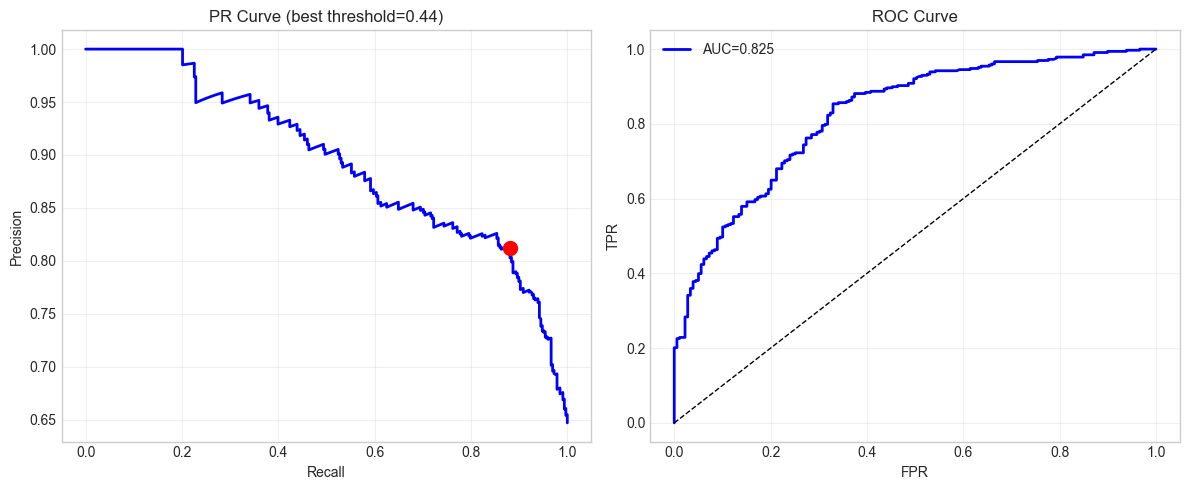

Optimal threshold: 0.4355
At threshold: Prec=0.812, Rec=0.881, F1=0.845


In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

prec, rec, thresholds = precision_recall_curve(y_te, prob_best)
f1_scores = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

axes[0].plot(rec, prec, 'b-', lw=2)
axes[0].scatter([rec[best_idx]], [prec[best_idx]], color='red', s=100, zorder=5)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title(f'PR Curve (best threshold={best_thresh:.2f})')
axes[0].grid(True, alpha=0.3)

fpr, tpr, _ = roc_curve(y_te, prob_best)
auc = roc_auc_score(y_te, prob_best)
axes[1].plot(fpr, tpr, 'b-', lw=2, label=f'AUC={auc:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Optimal threshold: {best_thresh:.4f}')
print(f'At threshold: Prec={prec[best_idx]:.3f}, Rec={rec[best_idx]:.3f}, F1={f1_scores[best_idx]:.3f}')

In [51]:
clf_results = pd.DataFrame([res1, res2, res3, res_best])
print('Classification Model Comparison:')
print(clf_results.round(4).to_string(index=False))

Classification Model Comparison:
           Model    Acc   Prec    Rec     F1    AUC
   RF Unbalanced 0.7692 0.7972 0.8628 0.8287 0.8160
     RF Balanced 0.7456 0.7741 0.8567 0.8133 0.8055
GradientBoosting 0.7633 0.8023 0.8415 0.8214 0.8197
        RF Tuned 0.7574 0.8233 0.7957 0.8093 0.8253


RF UNBALANCED
Precision:0.7972
Recall:0.8628
F1 Score:0.7376

Report:
              precision    recall  f1-score   support

           0     0.7039    0.5978    0.6465       179
           1     0.7972    0.8628    0.8287       328

    accuracy                         0.7692       507
   macro avg     0.7506    0.7303    0.7376       507
weighted avg     0.7643    0.7692    0.7644       507



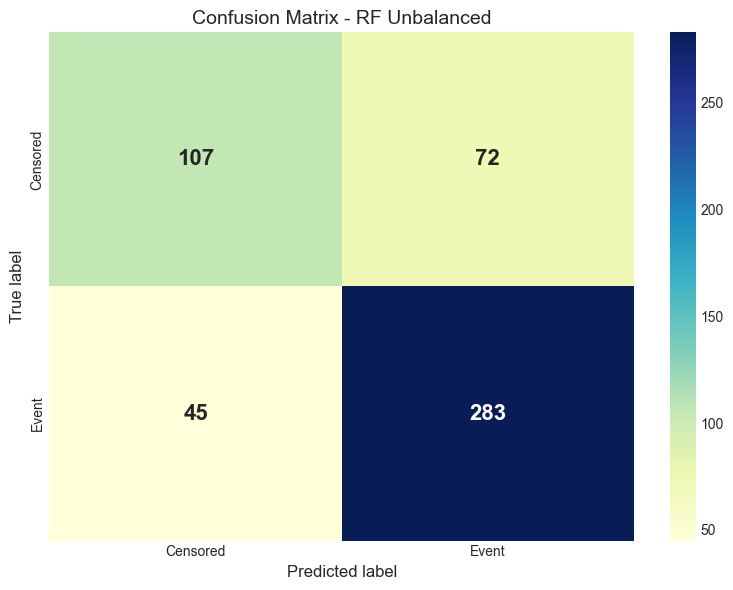

________________________________________________________________________________

RF BALANCED
Precision:0.7741
Recall:0.8567
F1 Score:0.7070

Report:
              precision    recall  f1-score   support

           0     0.6736    0.5419    0.6006       179
           1     0.7741    0.8567    0.8133       328

    accuracy                         0.7456       507
   macro avg     0.7239    0.6993    0.7070       507
weighted avg     0.7386    0.7456    0.7382       507



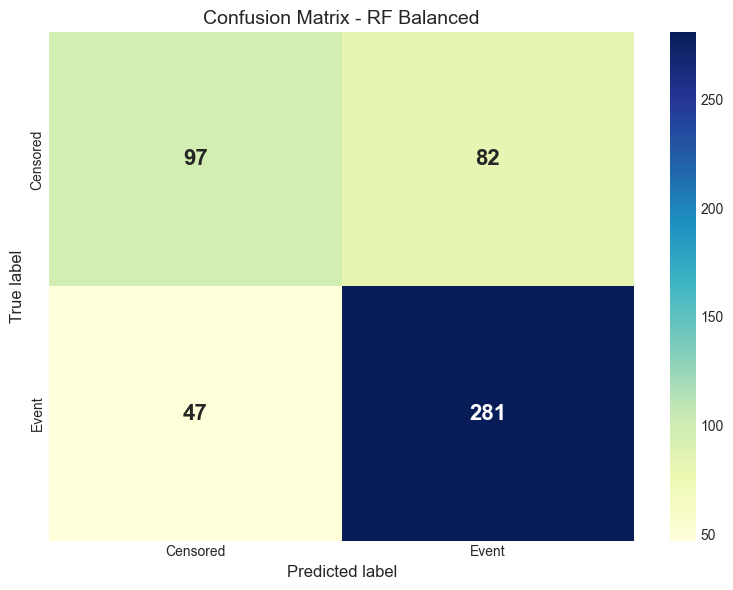

________________________________________________________________________________

GRADIENT BOOSTING
Precision:0.8023
Recall:0.8415
F1 Score:0.7353

Report:
              precision    recall  f1-score   support

           0     0.6810    0.6201    0.6491       179
           1     0.8023    0.8415    0.8214       328

    accuracy                         0.7633       507
   macro avg     0.7417    0.7308    0.7353       507
weighted avg     0.7595    0.7633    0.7606       507



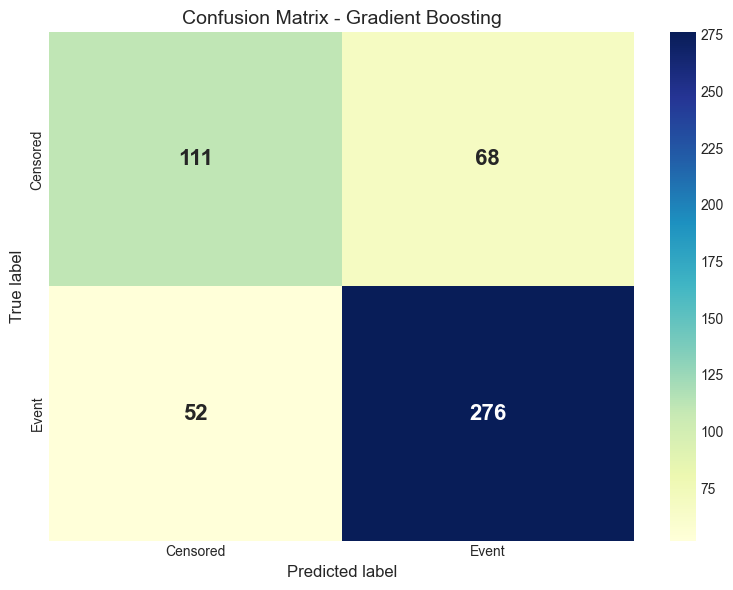

________________________________________________________________________________

RF TUNED
Precision:0.8233
Recall:0.7957
F1 Score:0.7380

Report:
              precision    recall  f1-score   support

           0     0.6474    0.6872    0.6667       179
           1     0.8233    0.7957    0.8093       328

    accuracy                         0.7574       507
   macro avg     0.7354    0.7414    0.7380       507
weighted avg     0.7612    0.7574    0.7589       507



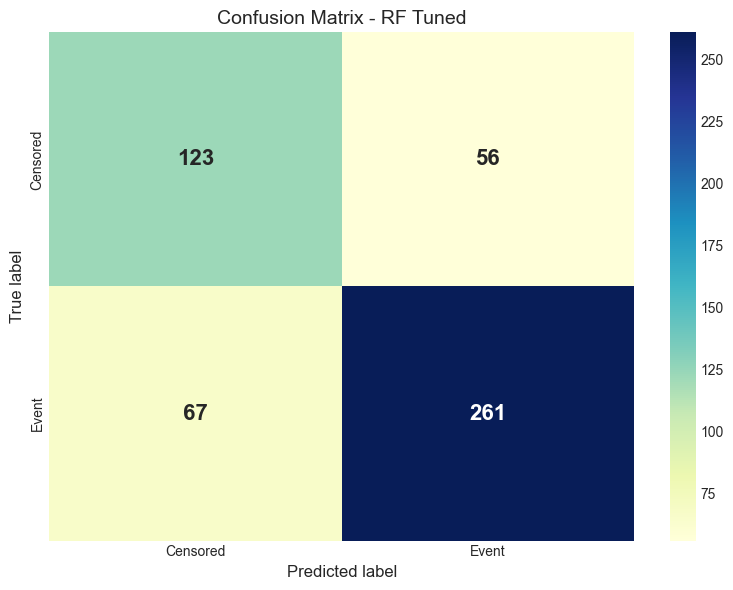

________________________________________________________________________________



In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

models = {
    'RF Unbalanced': rf1,
    'RF Balanced': rf2,
    'Gradient Boosting': gb,
    'RF Tuned': best_rf
}

for name, model in models.items():
    print(name.upper())
    
    y_pred = model.predict(X_te_s)
    
    f1 = f1_score(y_te, y_pred, average='macro')
    
    print(f'Precision:{precision_score(y_te, y_pred):.4f}')
    print(f'Recall:{recall_score(y_te, y_pred):.4f}')
    print(f'F1 Score:{f1:.4f}')
    print(f'\nReport:\n{classification_report(y_te, y_pred, digits=4)}')
    
    cm = confusion_matrix(y_te, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Censored', 'Event'],
                yticklabels=['Censored', 'Event'],
                annot_kws={'size': 16, 'weight': 'bold'},
                linewidths=0,
                linecolor='white',
                cbar=True,
                ax=ax)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_title(f'Confusion Matrix - {name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print('_' * 80)
    print()

## 7. Feature Importance Comparison

In [53]:
cox_imp = cph_full.summary['coef'].abs() 
cox_imp = cox_imp / cox_imp.max()

rsf_imp_s = rsf_imp.set_index('Feature')['Importance']
rsf_imp_s = rsf_imp_s / rsf_imp_s.max()

rf_imp = pd.Series(best_rf.feature_importances_, index=X_tr.columns)  
rf_imp = rf_imp / rf_imp.max()

imp_df = pd.DataFrame({'Cox': cox_imp, 'RSF': rsf_imp_s, 'RF': rf_imp}).fillna(0)
imp_df['Avg'] = imp_df.mean(axis=1)
imp_df = imp_df.sort_values('Avg', ascending=False)

print('Feature Importance (normalized):')
print(imp_df.head(12).round(3).to_string())

Feature Importance (normalized):
                                  Cox    RSF     RF    Avg
milestones                      0.656  1.000  0.557  0.738
log_fund_tot                    0.044  0.400  1.000  0.481
relationships                   0.007  0.104  0.948  0.353
funding_rounds                  0.464  0.327  0.221  0.337
macro_settore_OTHER             1.000  0.003  0.005  0.336
macro_settore_ENTERPRISE INFRA  0.744  0.007  0.018  0.256
macro_settore_TECH CORE         0.613  0.017  0.086  0.239
macro_settore_CONSUMER          0.589  0.004  0.013  0.202
market_heat                     0.064  0.077  0.335  0.159
macro_settore_COMMUNICATION     0.394  0.006  0.030  0.144
market_cycle_normal             0.385 -0.011  0.030  0.135
macro_settore_FINTECH           0.357  0.005  0.004  0.122


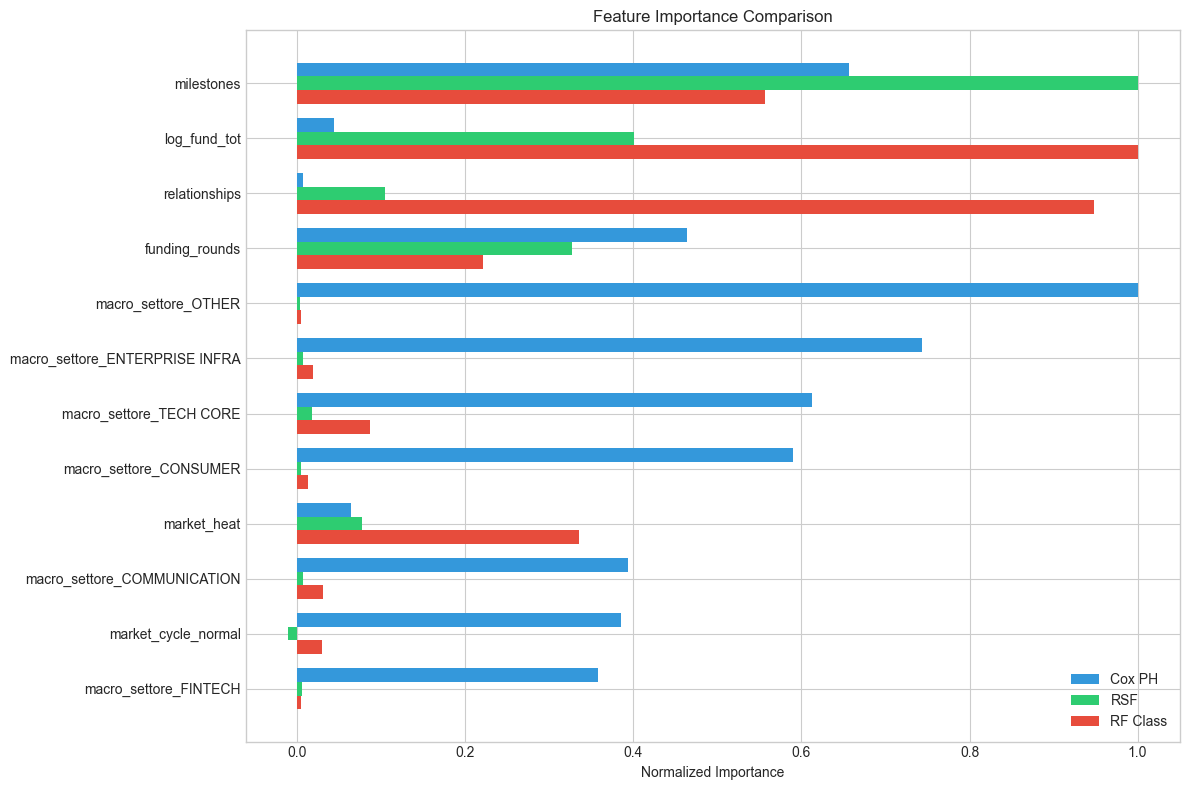

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))

top_f = imp_df.head(12).index
plot_d = imp_df.loc[top_f, ['Cox', 'RSF', 'RF']]
x = np.arange(len(top_f))
w = 0.25

ax.barh(x - w, plot_d['Cox'], w, label='Cox PH', color='#3498db')
ax.barh(x, plot_d['RSF'], w, label='RSF', color='#2ecc71')
ax.barh(x + w, plot_d['RF'], w, label='RF Class', color='#e74c3c')

ax.set_yticks(x)
ax.set_yticklabels(top_f)
ax.invert_yaxis()
ax.set_xlabel('Normalized Importance')
ax.set_title('Feature Importance Comparison')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Summary

In [55]:
import json

print(f'FINAL RESULTS SUMMARY')

print(f'\nDATASET')
print(f'- Total samples: {len(df):,}')
print(f'- Train: {len(train_idx):,} ({y_e_train.mean():.1%} events)')  
print(f'- Test: {len(test_idx):,} ({y_e_test.mean():.1%} events)')  
print(f'- Censored: {(df[E_TYPE]==0).sum():,} ({100*(df[E_TYPE]==0).mean():.1f}%)')
print(f'- IPO: {(df[E_TYPE]==1).sum():,} ({100*(df[E_TYPE]==1).mean():.1f}%)')
print(f'- M&A: {(df[E_TYPE]==2).sum():,} ({100*(df[E_TYPE]==2).mean():.1f}%)')
print(f'- Failure: {(df[E_TYPE]==3).sum():,} ({100*(df[E_TYPE]==3).mean():.1f}%)')

print(f'\nSURVIVAL MODELS (C-index)')
print(f'{"Model":<15} {"Train":>8} {"Test":>8} {"Overfit":>8}')
print(f'{"-"*42}')
print(f'{"Cox PH":<15} {ci_cox_train:>8.4f} {ci_cox_test:>8.4f} {ci_cox_train-ci_cox_test:>+8.4f}')
print(f'{"RSF":<15} {ci_rsf_train:>8.4f} {ci_rsf_test:>8.4f} {ci_rsf_train-ci_rsf_test:>+8.4f}')
if 'ci_xgb_test' in locals() and ci_xgb_test:
    print(f'{"XGBSE":<15} {ci_xgb_train:>8.4f} {ci_xgb_test:>8.4f} {ci_xgb_train-ci_xgb_test:>+8.4f}')

print(f'\nMODEL CALIBRATION')
print(f'- Integrated Brier Score: {ibs:.4f}')
print(f'- Mean Brier Score: {np.mean(brier_scores):.4f}')
print(f'- Mean Calibration Error (5y): {np.mean(np.abs(fraction_of_positives - mean_predicted_value)):.4f}')

print(f'\nCLASSIFICATION (Best Model: {res_best["Model"]})')
print(f'- Accuracy: {res_best["Acc"]:.4f}')
print(f'- Precision: {res_best["Prec"]:.4f}')
print(f'- Recall: {res_best["Rec"]:.4f}')
print(f'- F1: {res_best["F1"]:.4f}')
print(f'- AUC: {res_best["AUC"]:.4f}')

print(f'\nTOP 5 FEATURES (Average Importance)')
for i, (f, _) in enumerate(imp_df.head(5).iterrows(), 1):
    print(f'{i}. {f}')


# ========================================================================
# SAVE RESULTS (JSON COMPLETO)
# ========================================================================

results = {
    'survival': {
        'cox': {
            'train': float(ci_cox_train),
            'test': float(ci_cox_test),
            'overfit': float(ci_cox_train - ci_cox_test)
        },
        'rsf': {
            'train': float(ci_rsf_train),
            'test': float(ci_rsf_test),
            'overfit': float(ci_rsf_train - ci_rsf_test)
        },
        'xgbse': {
            'train': float(ci_xgb_train) if 'ci_xgb_train' in locals() and ci_xgb_train else None,
            'test': float(ci_xgb_test) if 'ci_xgb_test' in locals() and ci_xgb_test else None,
            'overfit': float(ci_xgb_train - ci_xgb_test) if 'ci_xgb_train' in locals() and ci_xgb_train else None
        }
    },
    'calibration': {
        'ibs': float(ibs),
        'brier_mean': float(np.mean(brier_scores)),
        'calibration_mae_5y': float(np.mean(np.abs(fraction_of_positives - mean_predicted_value)))
    },
    'classification': clf_results.to_dict('records'),
    'feature_importance': {
        k: {k2: float(v2) for k2, v2 in v.items()} 
        for k, v in imp_df.head(10).to_dict().items()
    },
    'dataset': {
        'n_samples': int(len(df)),
        'n_train': int(len(train_idx)), 
        'n_test': int(len(test_idx)),   
        'n_events': int(df[E].sum()),
        'event_rate': float(df[E].mean()),
        'event_distribution': {
            'Censored': int((df[E_TYPE] == 0).sum()),
            'IPO': int((df[E_TYPE] == 1).sum()),
            'M&A': int((df[E_TYPE] == 2).sum()),
            'Failure': int((df[E_TYPE] == 3).sum())
        },
        'event_percentages': {
            'Censored': float((df[E_TYPE] == 0).mean()),
            'IPO': float((df[E_TYPE] == 1).mean()),
            'M&A': float((df[E_TYPE] == 2).mean()),
            'Failure': float((df[E_TYPE] == 3).mean())
        }
    },
    'best_model': {
        'name': 'Random Survival Forest',
        'test_c_index': float(ci_rsf_test),
        'overfit_gap': float(ci_rsf_train - ci_rsf_test),
    }
}

# Save outputs
config.OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

dataset_path = config.OUTPUT_PATH / 'finale_usa_cleaned.csv'
df.to_csv(dataset_path, index=False)

results_path = config.OUTPUT_PATH / 'model_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2, default=str)
print('ANALYSIS COMPLETE')

FINAL RESULTS SUMMARY

DATASET
- Total samples: 15,304
- Train: 12,243 (10.7% events)
- Test: 3,061 (10.7% events)
- Censored: 12,796 (83.6%)
- IPO: 125 (0.8%)
- M&A: 1,513 (9.9%)
- Failure: 870 (5.7%)

SURVIVAL MODELS (C-index)
Model              Train     Test  Overfit
------------------------------------------
Cox PH            0.6786   0.6416  +0.0370
RSF               0.7684   0.6856  +0.0828
XGBSE             0.7134   0.6392  +0.0742

MODEL CALIBRATION
- Integrated Brier Score: 0.0859
- Mean Brier Score: 0.0747
- Mean Calibration Error (5y): 0.0491

CLASSIFICATION (Best Model: RF Tuned)
- Accuracy: 0.7574
- Precision: 0.8233
- Recall: 0.7957
- F1: 0.8093
- AUC: 0.8253

TOP 5 FEATURES (Average Importance)
1. milestones
2. log_fund_tot
3. relationships
4. funding_rounds
5. macro_settore_OTHER
ANALYSIS COMPLETE
